# Imports

In [8]:
! pip install -r ./requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [63]:
import sys
import os
# from src import preprocessor, clustering, classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import typing as th
import ast
from gensim.models import Word2Vec
import string
from scipy.stats import multivariate_normal, norm

import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

# Data

In [16]:
d_path = './'
train_data_df = pd.read_csv(d_path + 'data/train.csv.gz', compression='gzip')
test_data_df = pd.read_csv(d_path + 'data/test.csv.gz', compression='gzip')

train_data_df.head(2) # see how the data looks!

title                                               plot  \
0   Grumpier Old Men  A family wedding reignites the ancient feud be...   
1  Waiting to Exhale  Cheated on, mistreated and stepped on, the wom...   

   rating    genre popularity  
0     6.5  Romance    popular  
1     6.1  Romance    popular

# Preprocessor

In [17]:
DEFAULT_VECTOR_SIZE = 256
ENGLISH_NUMERICS = ''.join(str(i) for i in range(10))
ENGLISH_TRANSLATOR = str.maketrans('', '', ENGLISH_NUMERICS + string.punctuation)


class BasicPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.genre_labeler = LabelEncoder()
        self.popularity_labeler = LabelEncoder()

    def fit(self, x, y=None, **fit_params):
        self.genre_labeler.fit(x['genre'])
        self.popularity_labeler.fit(x['popularity'])
        return self

    def fit_transform(self, x, y=None, **fit_params):
        return self.fit(x, y, **fit_params).transform(x)

    def transform(self, x):
        result = x.copy()
        result['genre'] = self.genre_labeler.transform(x['genre'])
        result['popularity'] = self.popularity_labeler.transform(x['popularity'])
        result['info'] = (x['title'].map(str) + " " + x['plot'].map(str)).apply(
            lambda i: i.translate(ENGLISH_TRANSLATOR).lower())
        result['info-split'] = result['info'].apply(lambda i: i.split())
        result = result.drop(['rating', 'title', 'plot'], axis=1)
        return result


basic = BasicPreprocessor()

tf_idf_vectorizer = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('pca', TruncatedSVD())
])


class Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(
            self, n_components: int = DEFAULT_VECTOR_SIZE, w2v: th.Optional[dict] = None,
            tfidf: th.Optional[dict] = None):
        """
        :param n_components: dimension size of vectors
        :param w2v: optional dictionary containing w2v-specific parameters
        :param tfidf: optional dictionary containing tfidf-specific pipeline parameters
        """
        # setting up parameters
        self.n_components = n_components
        self.w2v = w2v or dict(size=DEFAULT_VECTOR_SIZE, min_count=2)
        self.tfidf = tfidf or dict()

        # initializing vectorizers
        self.w2v_vectorizer = None
        self.tf_idf_vectorizer = tf_idf_vectorizer
        self.tf_idf_vectorizer.set_params(**self.tfidf)

    def __filter_w2vs(self, vecs):
        return [self.w2v_vectorizer.wv[j] for j in vecs if j in self.w2v_vectorizer.wv]

    def fit(self, x, y=None):
        # finalizing parameters
        self.w2v['vector_size'] = self.w2v.get('vector_size', self.n_components)
        self.tfidf['pca__n_components'] = self.tfidf.get(
            'pca__n_components', self.n_components)
        self.tf_idf_vectorizer.set_params(**self.tfidf)
        # fitting models
        self.tf_idf_vectorizer.fit(x['info'])
        self.w2v_vectorizer = Word2Vec(sentences=x['info-split'], **self.w2v)
        return self

    def transform(self, x):
        result = x.copy()
        result['vec_1'] = self.tf_idf_vectorizer.transform(x['info']).tolist()
        #         try:
        #             # the walrus operator is only available for python>=3.8
        #             # you can uncomment these lines if you are on python>=3.8
        #             result['vec_2'] = x['info-split'].apply(
        #                 lambda i: sum(z) / len(z) if (
        #                     z := [self.w2v_vectorizer.wv[j] for j in i if j in self.w2v_vectorizer.wv]) else 'NA'
        #             )
        #         except SyntaxError:
        result['vec_2'] = x['info-split'].apply(
            lambda i: sum(self.__filter_w2vs(i)) / len(self.__filter_w2vs(i)) if (self.__filter_w2vs(i)) else 'NA')
        result = result.drop(['info', 'info-split'], axis=1)
        return result

    def fit_transform(self, x, y=None, **fit_params):
        return self.fit(x, y).transform(x)


preprocessor = Pipeline(steps=[
    ('preprocess', BasicPreprocessor()),
    ('vectorizer', Vectorizer())
])


# Preprocessing

In [18]:
# setup preprocessor
preprocessor.set_params(
    vectorizer__n_components=256, # dimensionality of the word vectors
    vectorizer__w2v={
        'epochs':128, # number of training iterations of the w2v model
        'min_count':2, # all words with total frequency lower than this will be ignored
    },
)
preprocessor.fit(train_data_df)
train_data = preprocessor.transform(train_data_df)
test_data = preprocessor.transform(test_data_df)

train_data.head(2) # see how the preprocessed data looks!

genre  popularity                                              vec_1  \
0      6           0  [0.14832711744162025, 0.009098200606936523, -0...   
1      6           0  [0.1654702632196905, -0.014032346107602628, -0...   

                                               vec_2  
0  [-0.43699175, 0.4642188, -0.08114053, -0.61384...  
1  [-0.7821593, 0.45089567, -0.002368524, -0.4079...

In [20]:
def prepair_df(df):

    '''
        preprocess dataframe from loaded data
        drops index
        converts vec_1 and vec_2 from string to array
    '''

    df_p = df.drop(columns = ['Unnamed: 0'])
    n = len(df_p)

    # vec_1 = []
    # vec_2 = []
    # for i in range(n):
    #     vec_1.append(list(map(float, df['vec_1'][i][1:-1].split(','))))
    #     vec_2.append(list(map(float, df['vec_2'][i][1:-1].split(''))))

    # df_p['vec_1'] = vec_1
    # df_p['vec_2'] = vec_2

    df_p['vec_1'] = df['vec_1'].map(ast.literal_eval)
    df_p['vec_2'] = df['vec_2'].map(ast.literal_eval)

    return df_p

# '''
#     load data
# '''
# train_df = pd.read_csv(d_path + 'data/train_data_preprocessed.csv')
# train_data = prepair_df(train_df)

# test_x = pd.read_csv(d_path + 'data/train_data_preprocessed.csv')
# test_data = prepair_df(train_df)

def vectorize_df(df, vec_name):

    '''
        vectorize data frame by vector_name:[vec_1, vec_2]
    '''

    vec_size = len(df[vec_name][0])
    n = len(df)

    columns_name = []
    for i in range(vec_size):
        columns_name.append('f_'+str(i))

    vals = []
    for i in range(n):
        vals.extend(df[vec_name][i])

    vals = np.array(vals)
    vals = vals.reshape((n, vec_size))


    df_n = pd.DataFrame(vals, columns = columns_name)
    df_n['genre'] = df['genre']
    df_n['popularity'] = df['popularity']

    return df_n

def split_X_y(df, column_name):
    y = df[column_name]
    X = df.drop(columns=[column_name])
    return X, y

In [22]:
# optional
validation_fraction = 0.1 # validation proportion
mask = np.random.rand(len(train_data)) < (1-validation_fraction)

val_split = train_data.iloc[~mask]
val_split = val_split.reset_index(drop=True)

train_split = train_data.iloc[mask]
train_split = train_split.reset_index(drop=True)

In [23]:
'''
    class for evaluation of target and predict
'''

class Evaluation:

    def __init__(self, predict, target):
        self.predict = np.array(predict)
        self.target = np.array(target)
        correct = np.logical_not(np.logical_xor(self.predict, self.target))
        self.N = len(self.target)
        self.TP = list(np.logical_and(correct, self.target)).count(True)
        self.TN = list(np.logical_and(correct, np.logical_not(self.target))).count(True)
        self.FP = list(np.logical_and(np.logical_not(correct), self.target)).count(True)
        self.FN = list(np.logical_and(np.logical_not(correct), np.logical_not(self.target))).count(True)

    def accuracy(self):
        return (self.TP + self.TN) / self.N

    def precision_pos(self):
        if (self.TP + self.FP) == 0:
            return None
        return self.TP/(self.TP + self.FP)

    def precision_neg(self):
        if (self.TN + self.FN) == 0:
            return None
        return self.TN/(self.TN + self.FN)

    def recall_pos(self):
        if (self.TP + self.FN) == 0:
            return None
        return self.TP/(self.TP + self.FN)

    def recall_neg(self):
        if (self.TP + self.FP) == 0:
            return None
        return self.TN/(self.TN + self.FP)

    def f_score_pos(self, alpha=0.5):
        if self.precision_pos() == None or self.recall_pos() == None:
            return None
        return 1 / ((alpha/self.precision_pos()) + ((1-alpha)/ self.recall_pos()))

    def f_score_neg(self, alpha=0.5):
        if self.precision_neg() == None or self.recall_neg() == None:
            return None
        return 1 / ((alpha/self.precision_neg()) + ((1-alpha)/ self.recall_neg()))

In [24]:
'''
    all variant of data
'''
# vec-1
data_train_vec_1 = vectorize_df(train_split, 'vec_1')
X_train_vec_1, y_train_vec_1 = split_X_y(data_train_vec_1, 'popularity')

data_val_vec_1 = vectorize_df(val_split, 'vec_1')
X_val_vec_1, y_val_vec_1 = split_X_y(data_val_vec_1, 'popularity')

data_test_vec_1 = vectorize_df(test_data, 'vec_1')
X_test_vec_1, y_test_vec_1 = split_X_y(data_test_vec_1, 'popularity')

# vec_2
data_train_vec_2 = vectorize_df(train_split, 'vec_2')
X_train_vec_2, y_train_vec_2 = split_X_y(data_train_vec_2, 'popularity')

data_val_vec_2 = vectorize_df(val_split, 'vec_2')
X_val_vec_2, y_val_vec_2 = split_X_y(data_val_vec_2, 'popularity')

data_test_vec_2 = vectorize_df(test_data, 'vec_2')
X_test_vec_2, y_test_vec_2 = split_X_y(data_test_vec_2, 'popularity')

# Classification

## Naive Bayes

In [28]:
class NaiveBayes :

    def __init__(self, kind, smooth_rate = 0):
        
        self.kind = kind
        self.smooth_rate = smooth_rate
        self.gaussian_params = None
        self.bernoulli_params = None
        self.multi_normals = None
    
    def covar(self ,X):
        '''
            X: np array
        '''
        shape = X.shape
        return np.cov(X.T) + self.smooth_rate * np.eye(shape[1])
    
    def fit_gaussian(self , X , y):
        '''
            X: np array
            y: np array
        '''

        idx_0 = y == 0
        idx_1 = y == 1

        p0 = np.mean(idx_0)
        p1 = np.mean(idx_1)

        m0 = np.mean(X[idx_0], axis = 0)
        m1 = np.mean(X[idx_1], axis = 0)

        s0 = self.covar(X[idx_0])
        s1 = self.covar(X[idx_1])

        self.gaussian_params = (p0, p1, m0, m1, s0, s1)
        
            
    def fit_bernoulli(self , X, threshold):
        '''
            X: np array
            threshold: int
        '''
        
        comp = np.zeros(X.shape[1])
        n = X.shape[0]
        for j in range(X.shape[1]):
            temp = X[:, j]
            comp[j] = (np.count_nonzero(temp[temp>threshold[j]]) + self.smooth_rate * n) / (X.shape[0] + 2 * self.smooth_rate * n)
        return comp    
            
    def fit(self, X_df, y_df):
        '''
            X: pd dataframe
            y: pd sereis
        '''

        X = np.array(X_df)
        y = np.array(y_df)

        self.fit_gaussian(X, y)
        
        if self.kind == 'gaussian':
            self.fit_gaussian(X, y)
            p0, p1, m0, m1, s0, s1 = self.gaussian_params
            self.multi_normals = [multivariate_normal(m0, s0), multivariate_normal(m1, s1)]
            
            
        if self.kind == 'bernoulli':
            threshold = np.mean(X, axis=0)
            self.bernoulli_params = [self.fit_bernoulli(X[y==0], threshold), self.fit_bernoulli(X[y==1], threshold)]

    def predict(self, X_df):

        X_test = np.array(X_df)
        
        predicts = []
        p0, p1, m0, m1, s0, s1 = self.gaussian_params
        
        if self.kind == "gaussian":
                        
            for x in X_test:
                predict_0 = self.multi_normals[0].logpdf(x).sum() + np.log(p0)
                predict_1 = self.multi_normals[1].logpdf(x).sum() + np.log(p1)
                
                if predict_0 > predict_1:
                    predicts.append(0)
                else:
                    predicts.append(1)
                       
            return np.array(predicts)

        if self.kind == "bernoulli":
            bp_0 = self.bernoulli_params[0]
            bp_1 = self.bernoulli_params[1]
            
            for x in X_test:
                predict_0 = np.log(p0) + (np.log((1-bp_0)-((x - m0)/np.sqrt(np.diagonal(s0))>=0)*(1-2*bp_0)).sum())
                
                predict_1 = np.log(p1) + (np.log((1-bp_1)-((x - m1)/np.sqrt(np.diagonal(s1))>=0)*(1-2*bp_1)).sum())
            
                if predict_0 > predict_1:
                        predicts.append(0)
                else:
                        predicts.append(1)
                       
            return np.array(predicts) 

In [29]:
types = ['gaussian', 'bernoulli']
smooth_rates = [0, 0.2, 0.5]

best_acc = 0
NB_best_1 = None
NB_best_type_1 = None
NB_best_sr_1 = -1

for t in types:
    for sr in smooth_rates:
            NB = NaiveBayes(t, sr)
            NB.fit(X_train_vec_1, y_train_vec_1)
            predict = NB.predict(X_val_vec_1)
            eval = Evaluation(predict, y_val_vec_1)
            acc = eval.accuracy()
            print('naive bayes type:', t,', vec_1: ', ', smooth rate:', sr, ', accuracy:',acc)
            if acc > best_acc:
                best_acc = acc
                NB_best_1 = NB
                NB_best_type_1 = t
                NB_best_sr_1 = sr

NB_best_predict_1 = NB_best_1.predict(X_test_vec_1)
NB_best_eval_1 = Evaluation(NB_best_predict_1, y_test_vec_1)
print('best Naive bayes type:', NB_best_type_1, ', vec_1:' , ', smooth rate:', NB_best_sr_1, ', accuracy:', NB_best_eval_1.accuracy())

best_acc = 0
NB_best_2 = None
NB_best_type_2 = None
NB_best_sr_2 = -1

for t in types:
    for sr in smooth_rates:
            NB = NaiveBayes(t, sr)
            NB.fit(X_train_vec_2, y_train_vec_2)
            predict = NB.predict(X_val_vec_2)
            eval = Evaluation(predict, y_val_vec_2)
            acc = eval.accuracy()
            print('naive bayes type:', t,', vec_1: ', ', smooth rate:', sr, ', accuracy:',acc)
            if acc > best_acc:
                best_acc = acc
                NB_best_2 = NB
                NB_best_type_2 = t
                NB_best_sr_2 = sr

NB_best_predict_2 = NB_best_2.predict(X_test_vec_2)
NB_best_eval_2 = Evaluation(NB_best_predict_2, y_test_vec_2)
print('best Naive bayes type:', NB_best_type_2, ', vec_2:' , ', smooth rate:', NB_best_sr_2, ', accuracy:', NB_best_eval_2.accuracy())

naive bayes type: gaussian , vec_1:  , smooth rate: 0 , accuracy: 0.6297909407665505
naive bayes type: gaussian , vec_1:  , smooth rate: 0.2 , accuracy: 0.5557491289198606
naive bayes type: gaussian , vec_1:  , smooth rate: 0.5 , accuracy: 0.5557491289198606
naive bayes type: bernoulli , vec_1:  , smooth rate: 0 , accuracy: 0.617595818815331
naive bayes type: bernoulli , vec_1:  , smooth rate: 0.2 , accuracy: 0.6097560975609756
naive bayes type: bernoulli , vec_1:  , smooth rate: 0.5 , accuracy: 0.5966898954703833
best Naive bayes type: gaussian , vec_1: , smooth rate: 0 , accuracy: 0.6167002012072434
naive bayes type: gaussian , vec_1:  , smooth rate: 0 , accuracy: 0.6123693379790941
naive bayes type: gaussian , vec_1:  , smooth rate: 0.2 , accuracy: 0.6332752613240418
naive bayes type: gaussian , vec_1:  , smooth rate: 0.5 , accuracy: 0.6306620209059234
naive bayes type: bernoulli , vec_1:  , smooth rate: 0 , accuracy: 0.6045296167247387
naive bayes type: bernoulli , vec_1:  , smooth

## KNN

In [30]:
import sklearn.neighbors

class KNN:
    def __init__(self, k, kind):
        '''
            k: int
        '''
        self.k = k
        self.kind = kind # [distance, cosine]
        
    def fit(self, X, y):
        self.X = X
        self.y = y

    def cosine_predict(self, X_test):
        X = np.array(self.X)
        y = np.array(self.y)

        z = np.array(X_test)
        M = np.dot(z, X.T)
        idx = M.argsort()
        idx = idx.T[:self.k].T
        predict = (np.sum(y[idx],axis=1) > self.k/2).astype(int)
        return predict

    def predict(self, X_test):
        if self.kind == 'distance':
            self.clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=self.k)
            self.clf.fit(self.X.values, self.y)
            # pdb.set_trace()
            return self.clf.predict(X_test.values)
            # return self.clf.predict(X_test)
        
        elif self.kind == 'cosine':
            return self.cosine_predict(X_test)

In [39]:
'''
    KNN comparison distance type
'''

types = ['distance', 'cosine']

ks = [3, 5, 25, 50, 100, 500]
X_train_KNN_array = [X_train_vec_1, X_train_vec_2]
X_val_KNN_array = [X_val_vec_1, X_val_vec_2]
X_test_KNN_array = [X_test_vec_1, X_test_vec_2]

y_train_KNN_array = [y_train_vec_1, y_train_vec_2]
y_val_KNN_array = [y_val_vec_1, y_val_vec_2]
y_test_KNN_array = [y_test_vec_1, y_test_vec_2]

KNN_best_1 = None
best_acc = 0
KNN_best_k_1 = -1
KNN_best_type_1 = None

# pdb.set_trace()
for t in types:
    for k in ks:
        knn = KNN(k, t)
        knn.fit(X_train_vec_1, y_train_vec_1)
        predict = knn.predict(X_val_vec_1)
        
        eval = Evaluation(predict, y_val_vec_1)
        acc = eval.accuracy()
        print('knn type:', t,', vec_1, k:', k, ', accuracy:',acc)
        if acc > best_acc:
            best_acc = acc
            KNN_best_1 = knn
            KNN_best_k_1 = k
            KNN_best_type_1 = t

KNN_best_predict_1 = KNN_best_1.predict(X_test_vec_1)
KNN_best_eval_1 = Evaluation(KNN_best_predict_1, y_test_vec_1)
print('best knn type:', KNN_best_type_1,', vec_1, k:', KNN_best_k_1, ', accuracy:', KNN_best_eval_1.accuracy())

KNN_best_2 = None
best_acc = 0
KNN_best_k_2 = -1
KNN_best_type_2 = None

for t in types:
    for k in ks:
        knn = KNN(k, t)
        knn.fit(X_train_vec_2, y_train_vec_2)
        predict = knn.predict(X_val_vec_2)
        eval = Evaluation(predict, y_val_vec_2)
        acc = eval.accuracy()
        print('knn type:', t,', vec_2, k:', k, ', accuracy:',acc)
        if acc > best_acc:
            best_acc = acc
            KNN_best_2 = knn
            KNN_best_k_2 = k
            KNN_best_type_2 = t

KNN_best_predict_2 = KNN_best_2.predict(X_test_vec_2)
KNN_best_eval_2 = Evaluation(KNN_best_predict_2, y_test_vec_2)
print('best knn type:', KNN_best_type_1,', vec_2, k:', KNN_best_k_1, ', accuracy:', KNN_best_eval_2.accuracy())

knn type: distance , vec_1, k: 3 , accuracy: 0.6141114982578397
knn type: distance , vec_1, k: 5 , accuracy: 0.6289198606271778
knn type: distance , vec_1, k: 25 , accuracy: 0.6350174216027874
knn type: distance , vec_1, k: 50 , accuracy: 0.6289198606271778
knn type: distance , vec_1, k: 100 , accuracy: 0.6297909407665505
knn type: distance , vec_1, k: 500 , accuracy: 0.6297909407665505
knn type: cosine , vec_1, k: 3 , accuracy: 0.47909407665505227
knn type: cosine , vec_1, k: 5 , accuracy: 0.4895470383275261
knn type: cosine , vec_1, k: 25 , accuracy: 0.4634146341463415
knn type: cosine , vec_1, k: 50 , accuracy: 0.45557491289198604
knn type: cosine , vec_1, k: 100 , accuracy: 0.43205574912891986
knn type: cosine , vec_1, k: 500 , accuracy: 0.44076655052264807
best knn type: distance , vec_1, k: 25 , accuracy: 0.613682092555332
knn type: distance , vec_2, k: 3 , accuracy: 0.6123693379790941
knn type: distance , vec_2, k: 5 , accuracy: 0.6167247386759582
knn type: distance , vec_2, k: 

## SVM

In [31]:
from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

'''
    SVM comparison
'''

kernels = ['linear', 'poly', 'rbf']
cs = [10**i for i in range(-1,2)] #range(-1,2)

best_acc = 0
SVM_best_1 = None
SVM_best_kernel_1 = None
SVM_best_c_1 = None


for kernel in kernels:
    for c in cs:
        clf = SVC(kernel=kernel, C=c)
        clf.fit(X_train_vec_1, y_train_vec_1)
        p = clf.predict(X_val_vec_1)
        eval = Evaluation(p, y_val_vec_1)
        acc = eval.accuracy()
        print('SVM, kernel:', kernel, ', vec_1, C:', c,', accuracy:', acc)
        if acc > best_acc:
            best_acc = acc
            SVM_best_1 = clf
            SVM_best_kernel_1 = kernel
            SVM_best_c_1 = c

SVM_best_predict_1 = SVM_best_1.predict(X_test_vec_1)
SVM_best_eval_1 = Evaluation(SVM_best_predict_1, y_test_vec_1)
print('best SVM, kernel:', SVM_best_kernel_1, 'vec_1, C:', SVM_best_c_1,'accuracy:', SVM_best_eval_1.accuracy())

best_acc = 0
SVM_best_2 = None
SVM_best_kernel_2 = None
SVM_best_c_2 = None


for kernel in kernels:
    for c in cs:
        clf = SVC(kernel=kernel, C=c)
        clf.fit(X_train_vec_2, y_train_vec_2)
        p = clf.predict(X_val_vec_2)
        eval = Evaluation(p, y_val_vec_2)
        acc = eval.accuracy()
        print('SVM, kernel:', kernel, ', vec_2, C:', c,', accuracy:', acc)
        if acc > best_acc:
            best_acc = acc
            SVM_best_2 = clf
            SVM_best_kernel_2 = kernel
            SVM_best_c_2 = c

SVM_best_predict_2 = SVM_best_2.predict(X_test_vec_2)
SVM_best_eval_2 = Evaluation(SVM_best_predict_2, y_test_vec_2)
print('best SVM, kernel:', SVM_best_kernel_2, 'vec_2, C:', SVM_best_c_2,'accuracy:', SVM_best_eval_2.accuracy())

SVM, kernel: linear , vec_1, C: 0.1 , accuracy: 0.5923344947735192
SVM, kernel: linear , vec_1, C: 1 , accuracy: 0.6411149825783972
SVM, kernel: linear , vec_1, C: 10 , accuracy: 0.6385017421602788
SVM, kernel: poly , vec_1, C: 0.1 , accuracy: 0.5522648083623694
SVM, kernel: poly , vec_1, C: 1 , accuracy: 0.6132404181184669
SVM, kernel: poly , vec_1, C: 10 , accuracy: 0.6123693379790941
SVM, kernel: rbf , vec_1, C: 0.1 , accuracy: 0.5452961672473867
SVM, kernel: rbf , vec_1, C: 1 , accuracy: 0.6088850174216028
SVM, kernel: rbf , vec_1, C: 10 , accuracy: 0.632404181184669
best SVM, kernel: linear vec_1, C: 1 accuracy: 0.635814889336016
SVM, kernel: linear , vec_2, C: 0.1 , accuracy: 0.6393728222996515
SVM, kernel: linear , vec_2, C: 1 , accuracy: 0.6367595818815331
SVM, kernel: linear , vec_2, C: 10 , accuracy: 0.6358885017421603
SVM, kernel: poly , vec_2, C: 0.1 , accuracy: 0.6114982578397212
SVM, kernel: poly , vec_2, C: 1 , accuracy: 0.6350174216027874
SVM, kernel: poly , vec_2, C: 1

## Neural Network

In [32]:
class Neural_Network:
    def __init__(self, hidden_layer_sizes = (32, 32), activation = 'relu'):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation)

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X_test):
        return self.clf.predict(X_test)

In [48]:
hidden_layers = [(32,32), (32,32,32), (16,16)]
activations = ['relu', 'relu', 'relu']
pairs = [[(32,32), 'relu'], [(32,32,32), 'relu'], [(16,16), 'relu']]


best_acc = 0
NN_best_1 = None
NN_best_pair_1 = None

for pair in pairs:
    HLS = pair[0]
    activation = pair[1]

    NN = Neural_Network(HLS, activation)
    NN.fit(X_train_vec_1, y_train_vec_1)
    predict = NN.predict(X_val_vec_1)
    eval = Evaluation(predict, y_val_vec_1)
    acc = eval.accuracy()
    print('Neural_Network: vec_1, activation: ', activation, ',hidden_layer_size:', str(HLS), ',accuracy:', acc)
    if acc > best_acc:
        NN_best_1 = NN
        NN_best_pair_1 = pair
    
NN_best_predict_1 = NN_best_1.predict(X_test_vec_1)
NN_best_eval_1 = Evaluation(NN_best_predict_1, y_test_vec_1)
print('best Neural_Network: vec_1, activation: ', NN_best_pair_1[0], ', hidden_layer_size:', str(NN_best_pair_1[1]), ', accuracy:', NN_best_eval_1.accuracy())

best_acc = 0
NN_best_2 = None
NN_best_pair_2 = None

for pair in pairs:
    HLS = pair[0]
    activation = pair[1]

    NN = Neural_Network(HLS, activation)
    NN.fit(X_train_vec_2, y_train_vec_2)
    predict = NN.predict(X_val_vec_2)
    eval = Evaluation(predict, y_val_vec_2)
    acc = eval.accuracy()
    print('Neural_Network: vec_2, activation: ', activation, ',hidden_layer_size:', str(HLS), ',accuracy:', acc)
    if acc > best_acc:
        NN_best_2 = NN
        NN_best_pair_2 = pair
    
NN_best_predict_2 = NN_best_2.predict(X_test_vec_2)
NN_best_eval_2 = Evaluation(NN_best_predict_2, y_test_vec_2)
print('best Neural_Network: vec_2, activation: ', NN_best_pair_2[0], ', hidden_layer_size:', str(NN_best_pair_2[1]), ', accuracy:', NN_best_eval_2.accuracy())

/home/amin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural_Network: vec_1, activation:  relu ,hidden_layer_size: (32, 32) ,accuracy: 0.5749128919860628
Neural_Network: vec_1, activation:  relu ,hidden_layer_size: (32, 32, 32) ,accuracy: 0.5749128919860628


/home/amin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural_Network: vec_1, activation:  relu ,hidden_layer_size: (16, 16) ,accuracy: 0.6132404181184669
best Neural_Network: vec_1, activation:  (16, 16) , hidden_layer_size: relu , accuracy: 0.6056338028169014


/home/amin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural_Network: vec_2, activation:  relu ,hidden_layer_size: (32, 32) ,accuracy: 0.5696864111498258
Neural_Network: vec_2, activation:  relu ,hidden_layer_size: (32, 32, 32) ,accuracy: 0.5452961672473867
Neural_Network: vec_2, activation:  relu ,hidden_layer_size: (16, 16) ,accuracy: 0.5949477351916377
best Neural_Network: vec_2, activation:  (16, 16) , hidden_layer_size: relu , accuracy: 0.5860160965794768


/home/amin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Analysis

In [49]:
'''
    vec_1
'''
cols = ['accuracy', 'f_score_pos', 'precision_pos', 'recall_pos', 'f_score_neg', 'precision_neg', 'recall_neg']
NB_col = [NB_best_eval_1.accuracy(), NB_best_eval_1.f_score_pos(), NB_best_eval_1.precision_pos(), NB_best_eval_1.recall_pos(), NB_best_eval_1.f_score_neg(), NB_best_eval_1.precision_neg(), NB_best_eval_1.recall_neg()]
KNN_col = [KNN_best_eval_1.accuracy(), KNN_best_eval_1.f_score_pos(), KNN_best_eval_1.precision_pos(), KNN_best_eval_1.recall_pos(), KNN_best_eval_1.f_score_neg(), KNN_best_eval_1.precision_neg(), KNN_best_eval_1.recall_neg()]
SVM_col = [SVM_best_eval_1.accuracy(), SVM_best_eval_1.f_score_pos(), SVM_best_eval_1.precision_pos(), SVM_best_eval_1.recall_pos(), SVM_best_eval_1.f_score_neg(), SVM_best_eval_1.precision_neg(), SVM_best_eval_1.recall_neg()]
NN_col = [NN_best_eval_1.accuracy(), NN_best_eval_1.f_score_pos(), NN_best_eval_1.precision_pos(), NN_best_eval_1.recall_pos(), NN_best_eval_1.f_score_neg(), NN_best_eval_1.precision_neg(), NN_best_eval_1.recall_neg()]

eval_df = pd.DataFrame()
eval_df['cols'] = cols
eval_df['NB'] = NB_col
eval_df['KNN'] = KNN_col
eval_df['SVM'] = SVM_col
eval_df['NN'] = NN_col

print('vec_1:')
eval_df

vec_1:


cols        NB       KNN       SVM        NN
0       accuracy  0.616700  0.613682  0.635815  0.605634
1    f_score_pos  0.553864  0.498039  0.554187  0.553022
2  precision_pos  0.515812  0.415485  0.490731  0.528899
3     recall_pos  0.597977  0.621533  0.636492  0.579450
4    f_score_neg  0.664021  0.686018  0.692177  0.647165
5  precision_neg  0.703081  0.783380  0.760037  0.671335
6     recall_neg  0.629073  0.610182  0.635441  0.624674

In [50]:
'''
    vec_2
'''
cols = ['accuracy', 'f_score_pos', 'precision_pos', 'recall_pos', 'f_score_neg', 'precision_neg', 'recall_neg']
NB_col = [NB_best_eval_2.accuracy(), NB_best_eval_2.f_score_pos(), NB_best_eval_2.precision_pos(), NB_best_eval_2.recall_pos(), NB_best_eval_2.f_score_neg(), NB_best_eval_2.precision_neg(), NB_best_eval_2.recall_neg()]
KNN_col = [KNN_best_eval_2.accuracy(), KNN_best_eval_2.f_score_pos(), KNN_best_eval_2.precision_pos(), KNN_best_eval_2.recall_pos(), KNN_best_eval_2.f_score_neg(), KNN_best_eval_2.precision_neg(), KNN_best_eval_2.recall_neg()]
SVM_col = [SVM_best_eval_2.accuracy(), SVM_best_eval_2.f_score_pos(), SVM_best_eval_2.precision_pos(), SVM_best_eval_2.recall_pos(), SVM_best_eval_2.f_score_neg(), SVM_best_eval_2.precision_neg(), SVM_best_eval_2.recall_neg()]
NN_col = [NN_best_eval_2.accuracy(), NN_best_eval_2.f_score_pos(), NN_best_eval_2.precision_pos(), NN_best_eval_2.recall_pos(), NN_best_eval_2.f_score_neg(), NN_best_eval_2.precision_neg(), NN_best_eval_2.recall_neg()]

eval_df = pd.DataFrame()
eval_df['cols'] = cols
eval_df['NB'] = NB_col
eval_df['KNN'] = KNN_col
eval_df['SVM'] = SVM_col
eval_df['NN'] = NN_col

print('vec_2:')
eval_df

vec_2:


cols        NB       KNN       SVM        NN
0       accuracy  0.626258  0.623239  0.623742  0.586016
1    f_score_pos  0.620725  0.556017  0.582589  0.567979
2  precision_pos  0.663032  0.511450  0.569248  0.589967
3     recall_pos  0.583493  0.609091  0.596571  0.547571
4    f_score_neg  0.631631  0.672783  0.657509  0.602607
5  precision_neg  0.594771  0.718954  0.670401  0.582633
6     recall_neg  0.673362  0.632184  0.645103  0.624000

# Plots

In [51]:
def plot_classes(df, y, title):
    classes = np.unique(y)
    plt.figure(figsize=(15,15))
    for c in classes:
        idx = y == c
        f0, f1 = df['f_0'][idx], df['f_1'][idx]
        plt.scatter(f0,f1, label='class_'+str(c))

    plt.legend()
    plt.xlabel('first most important feature', fontsize=15)
    plt.ylabel('second most importatn feature', fontsize=15)
    plt.title(title, fontsize=20)
    plt.show()

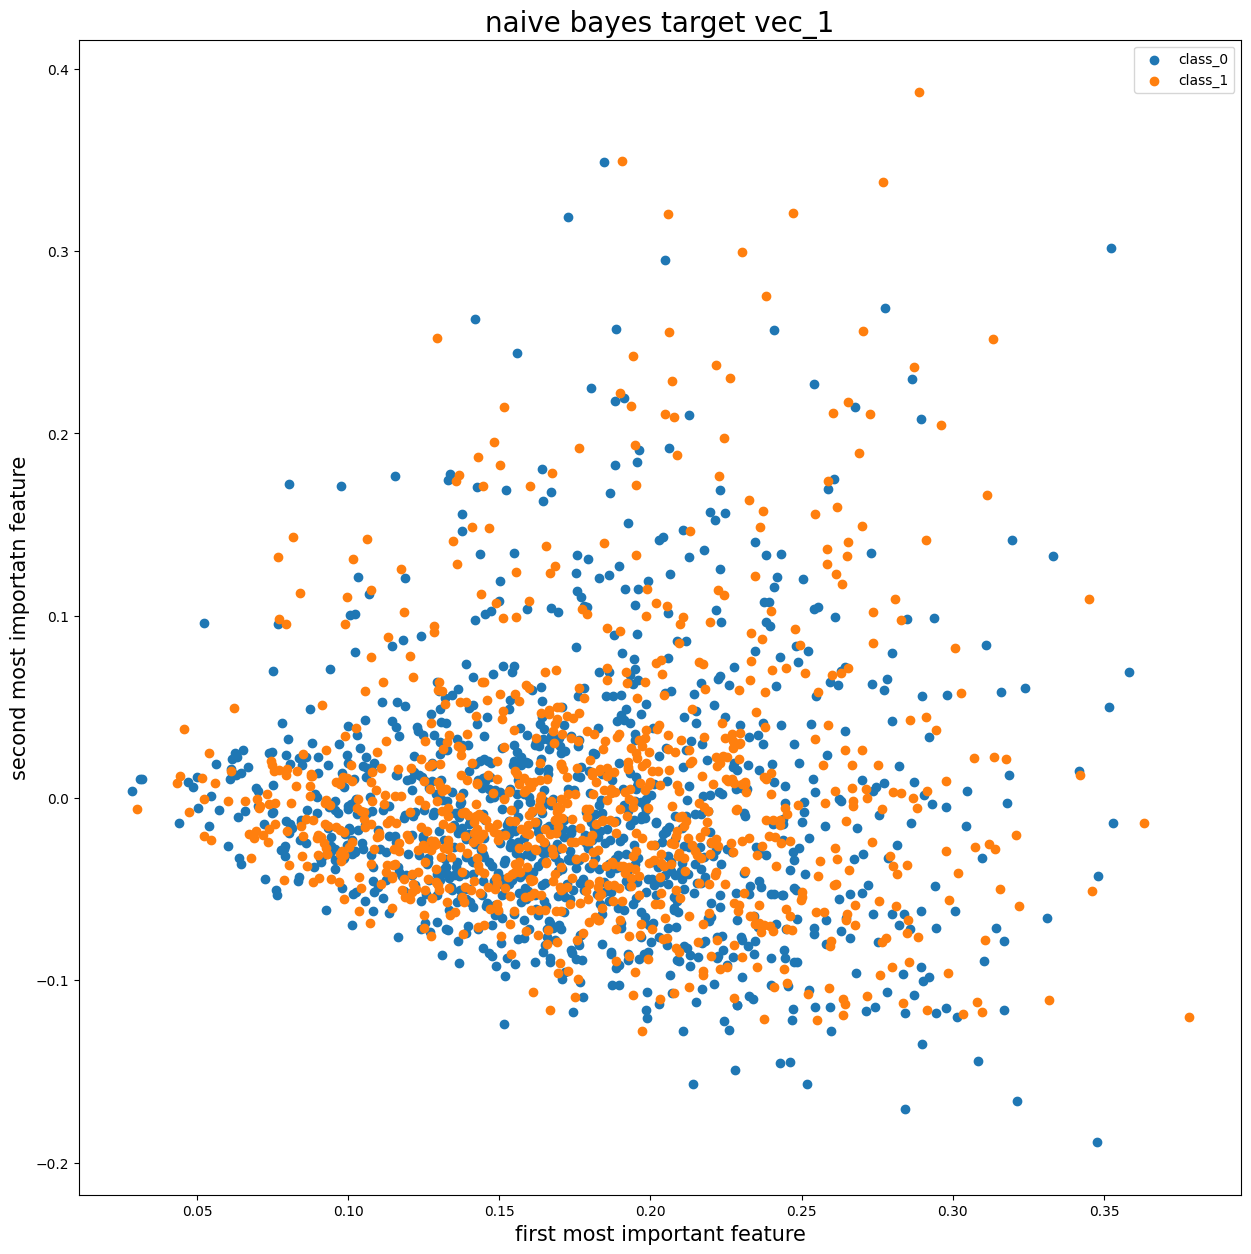

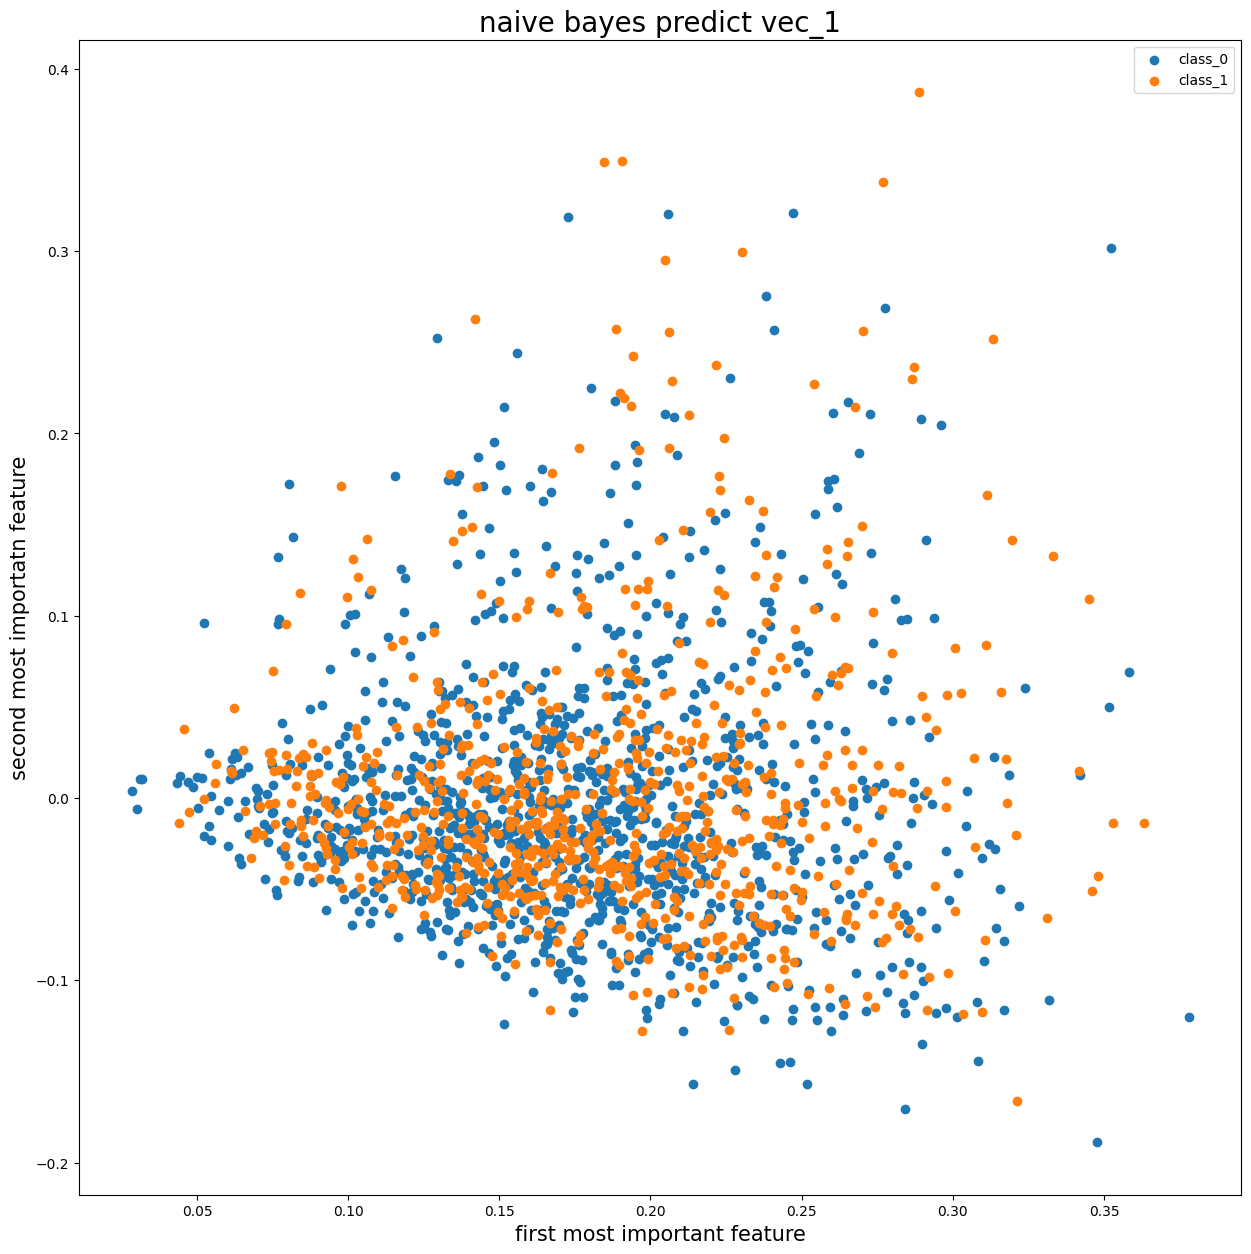

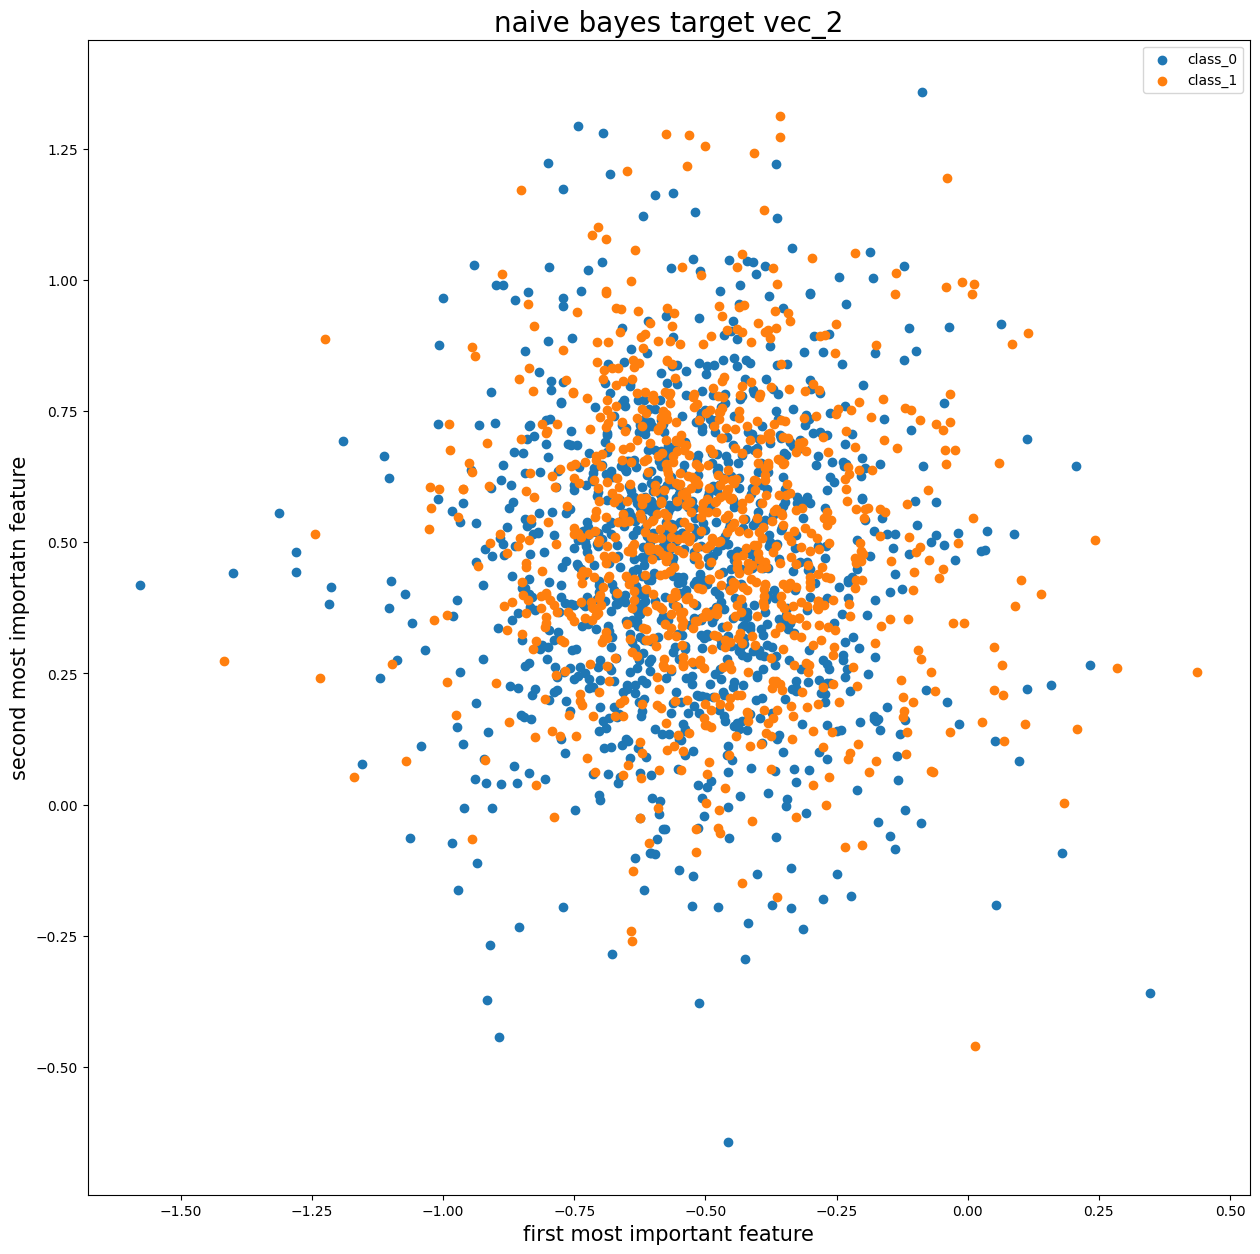

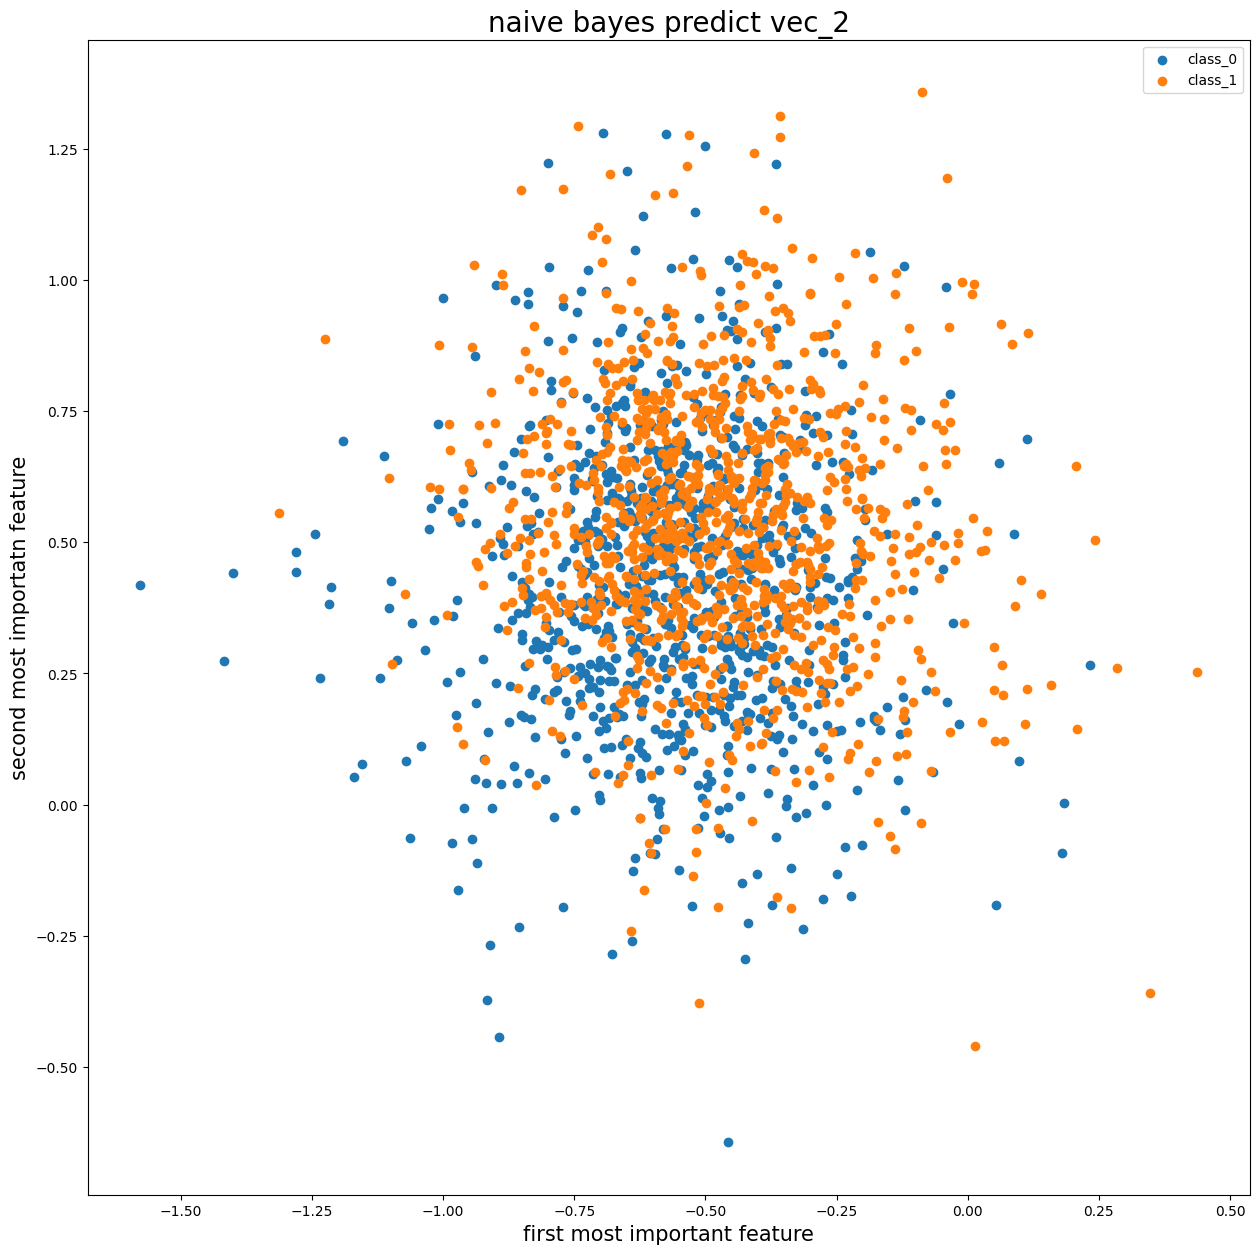

In [52]:
'''
    naive bayes
'''
plot_classes(data_test_vec_1, y_test_vec_1, 'naive bayes target vec_1')
plot_classes(data_test_vec_1, NB_best_predict_1, 'naive bayes predict vec_1')

plot_classes(data_test_vec_2, y_test_vec_2, 'naive bayes target vec_2')
plot_classes(data_test_vec_2, NB_best_predict_2, 'naive bayes predict vec_2')

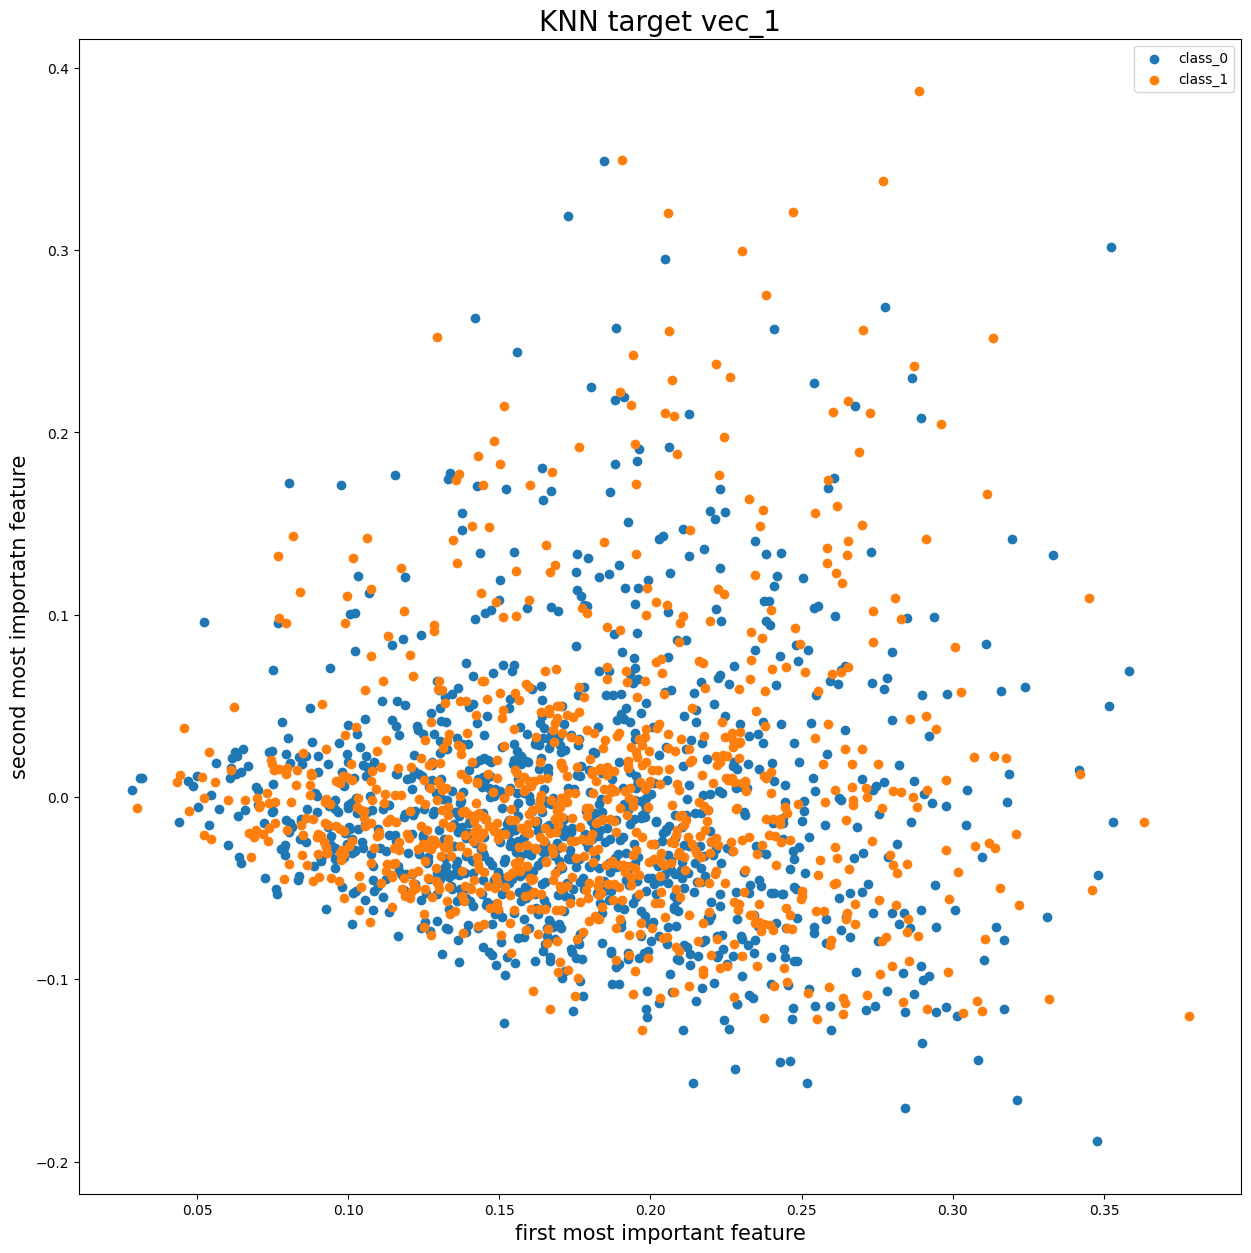

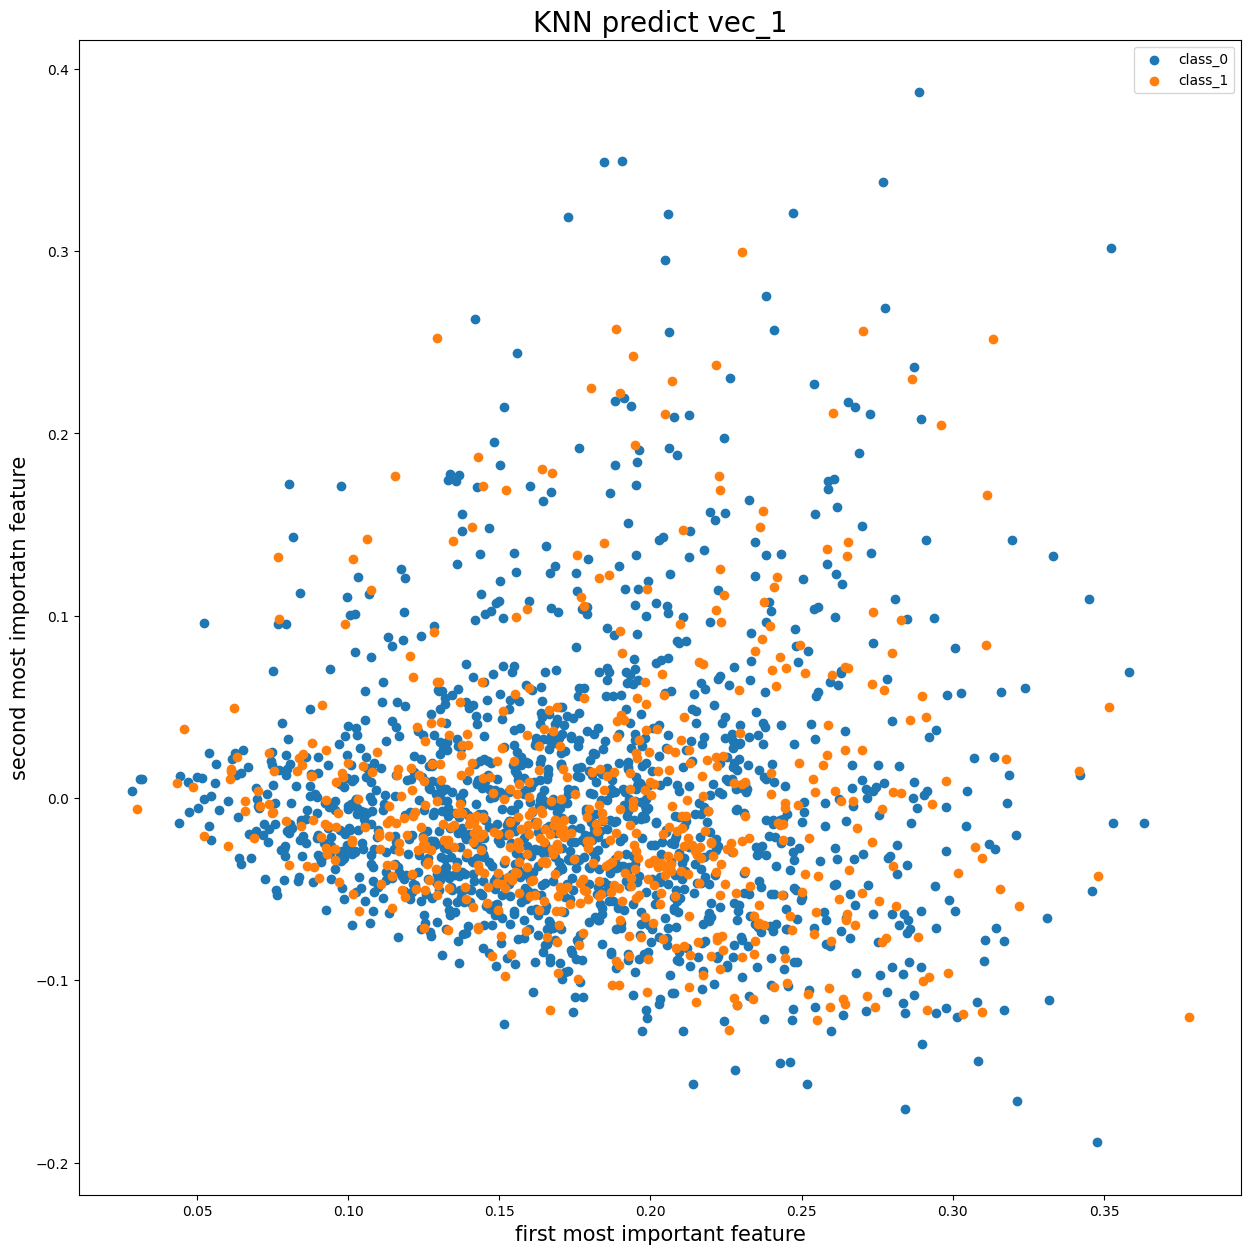

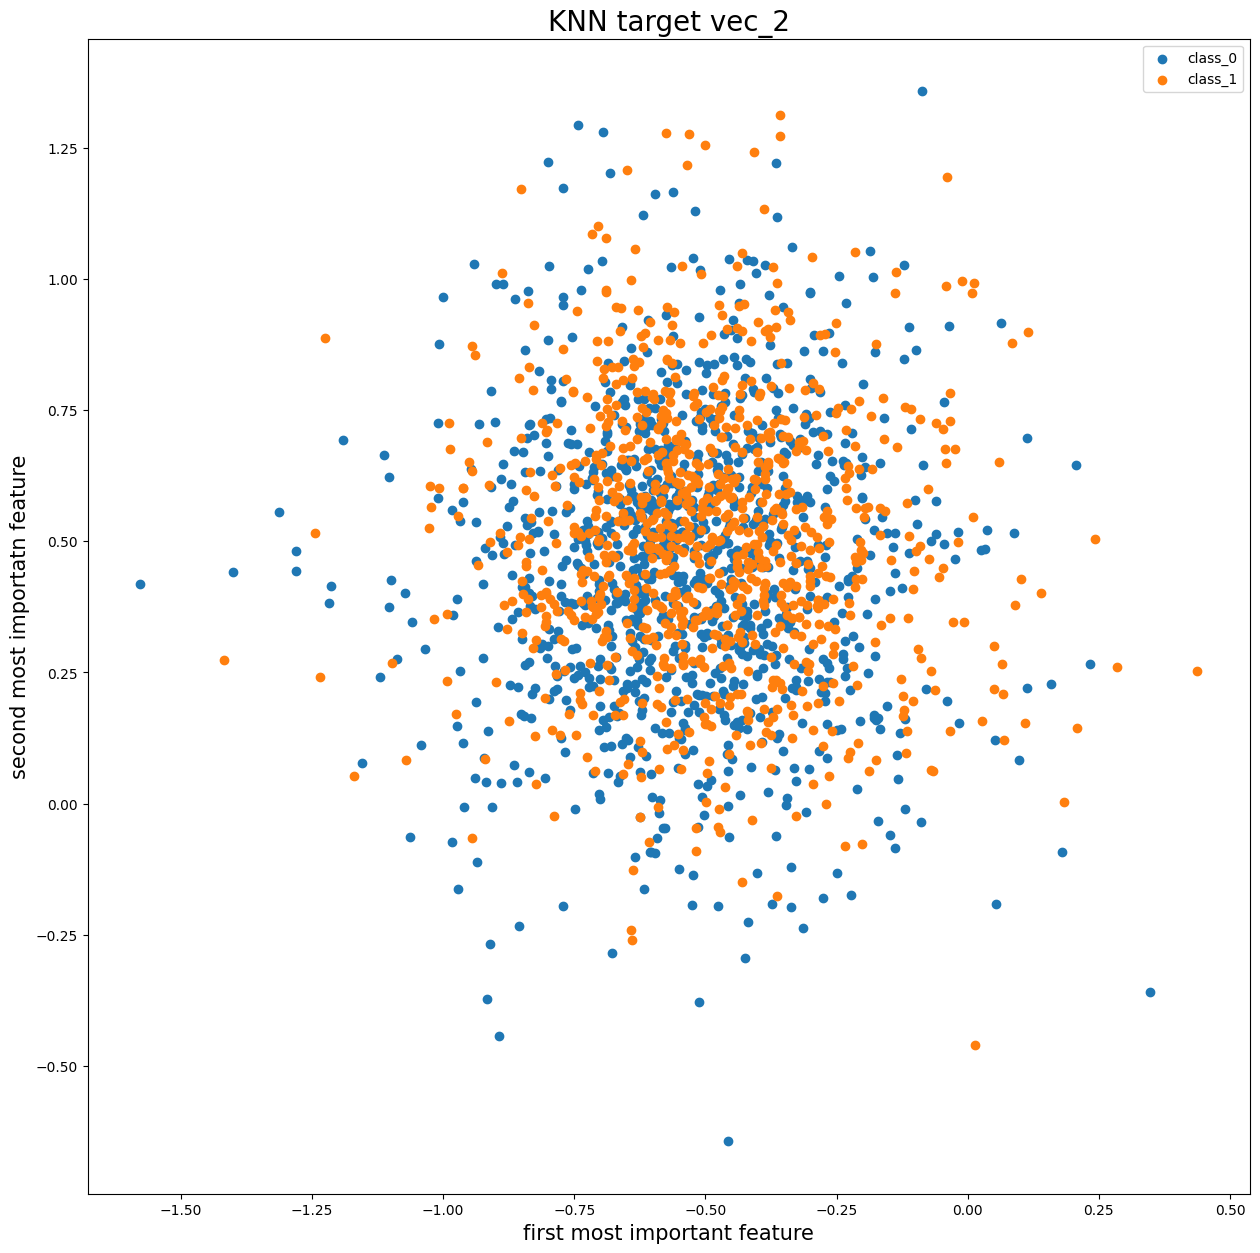

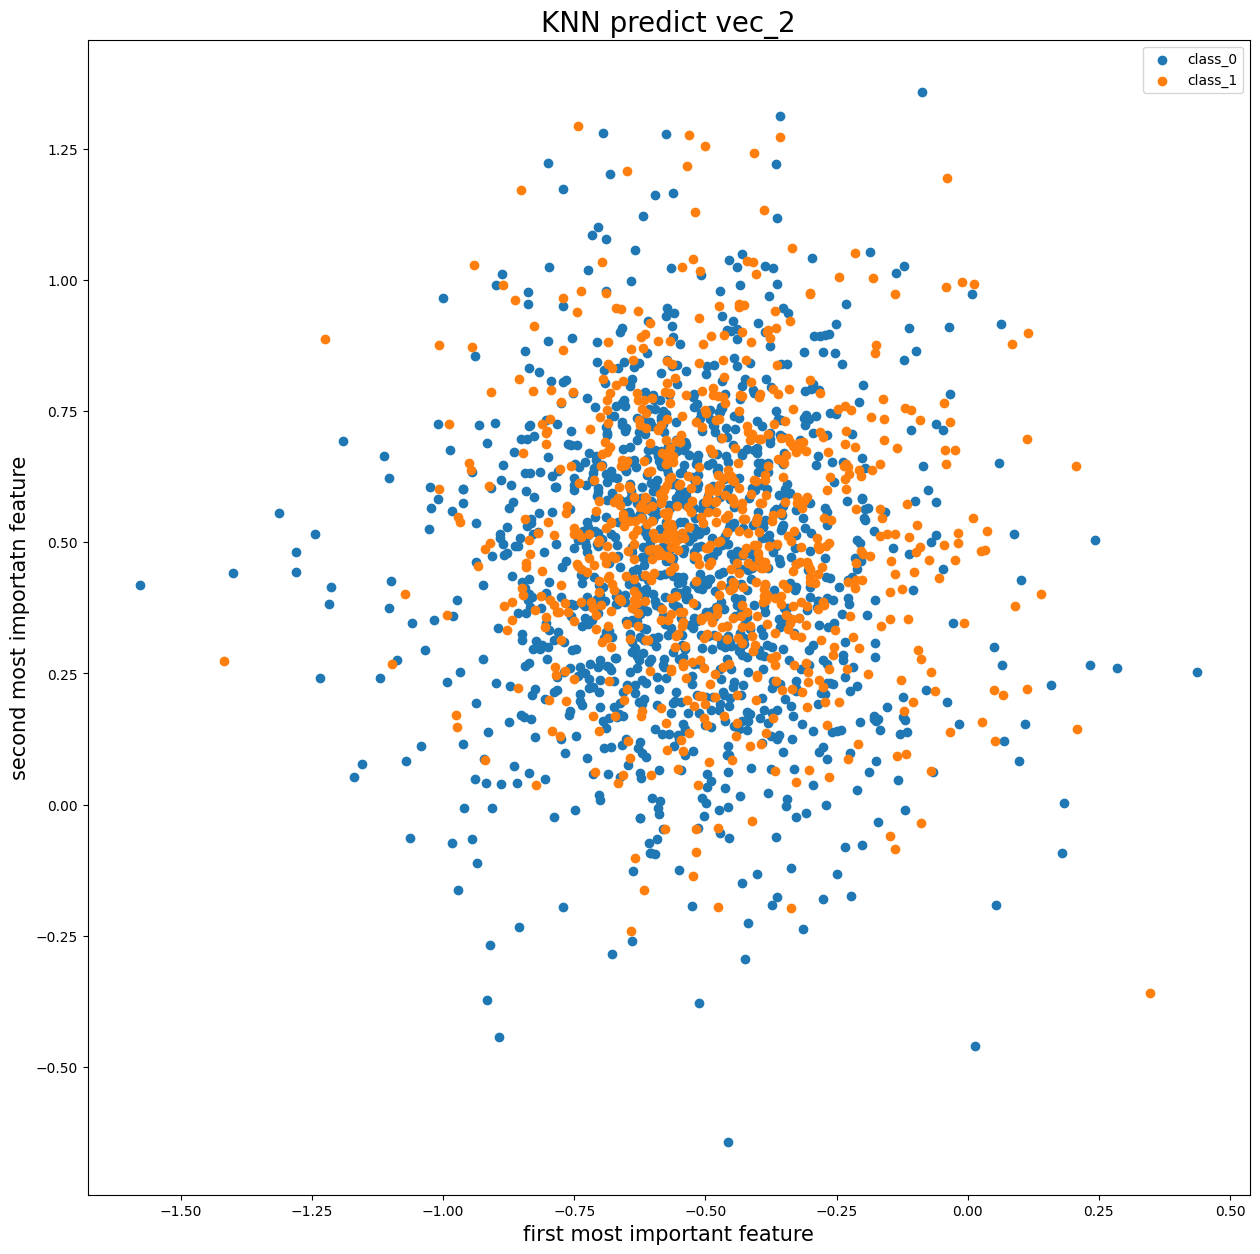

In [53]:
'''
    KNN
'''
plot_classes(data_test_vec_1, y_test_vec_1, 'KNN target vec_1')
plot_classes(data_test_vec_1, KNN_best_predict_1, 'KNN predict vec_1')

plot_classes(data_test_vec_2, y_test_vec_2, 'KNN target vec_2')
plot_classes(data_test_vec_2, KNN_best_predict_2, 'KNN predict vec_2')

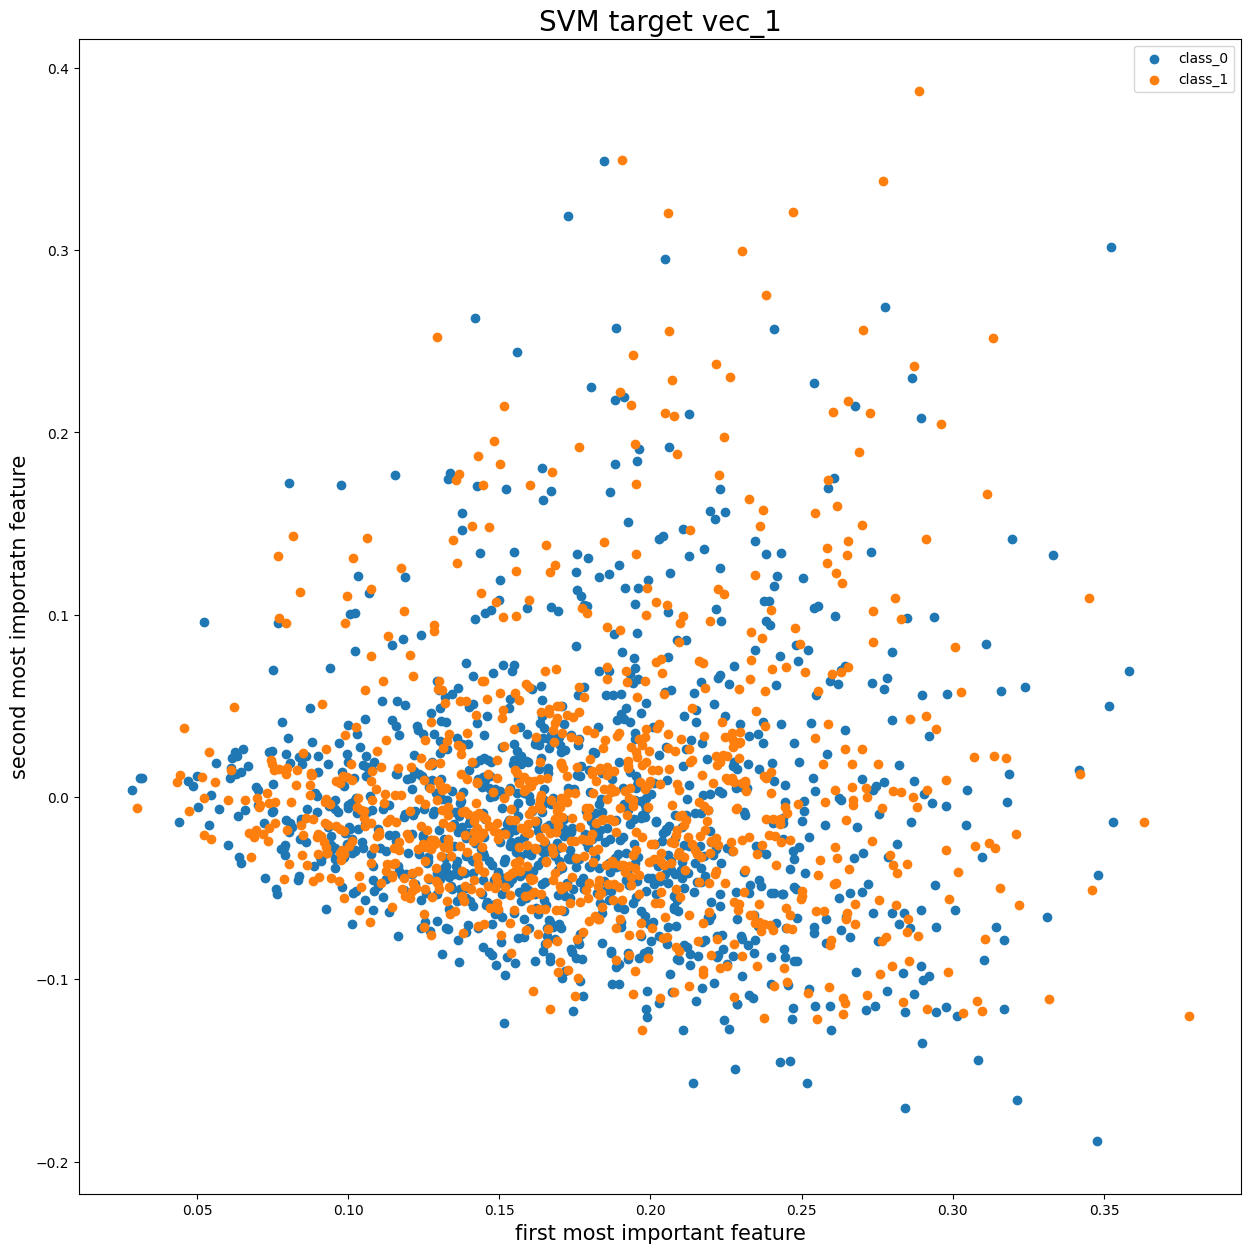

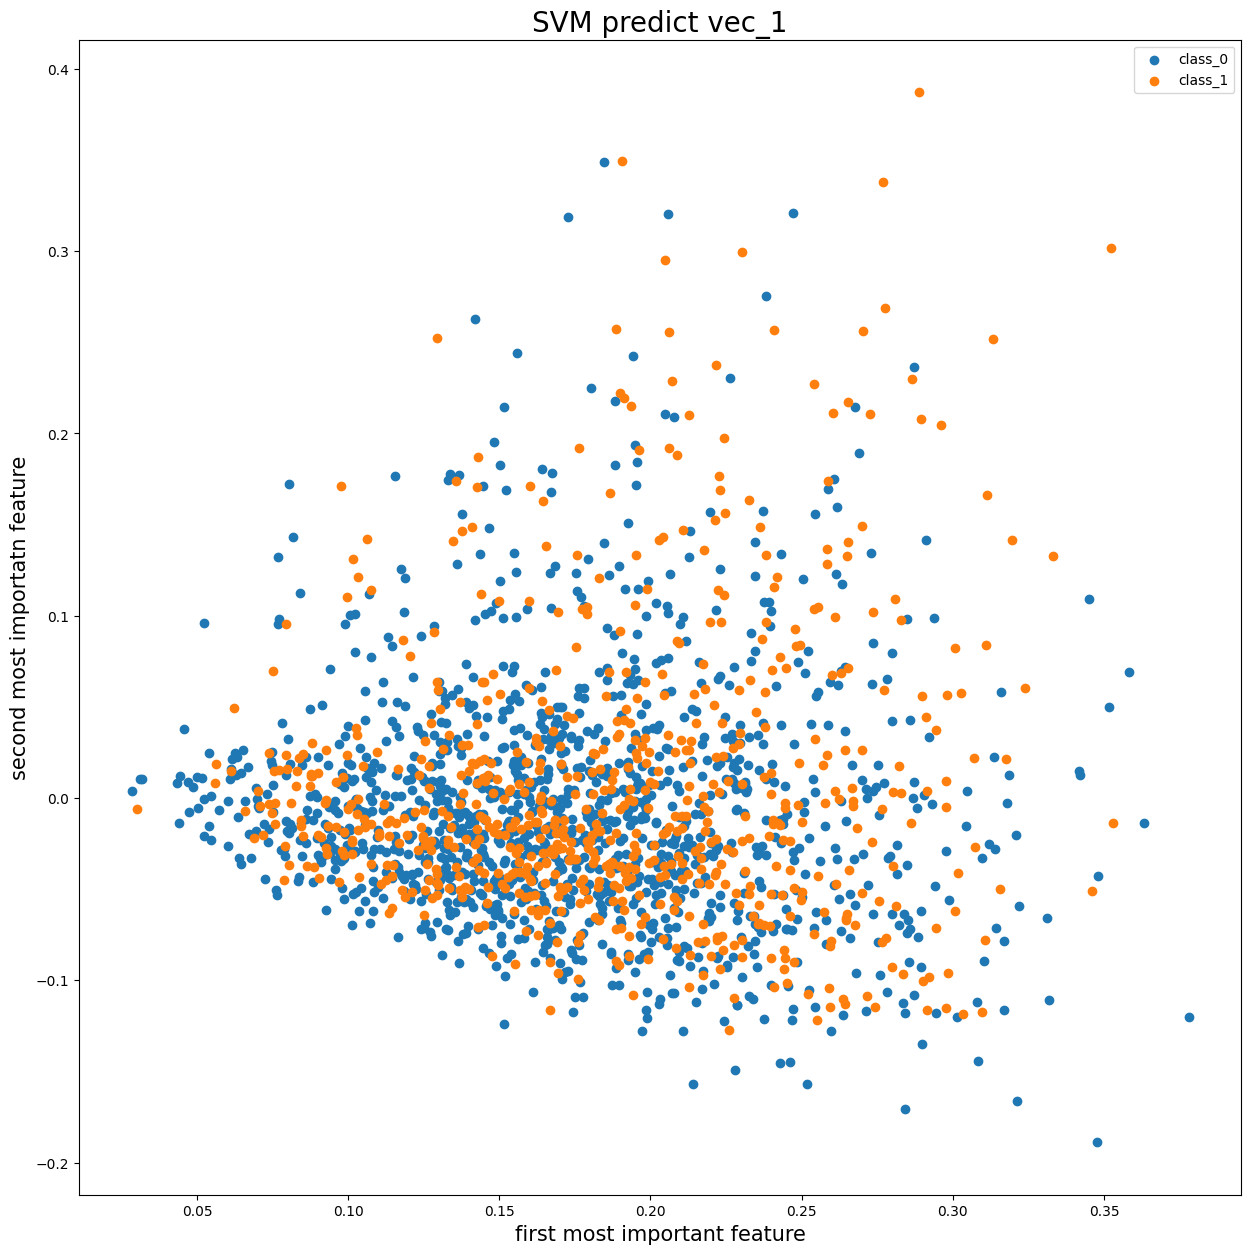

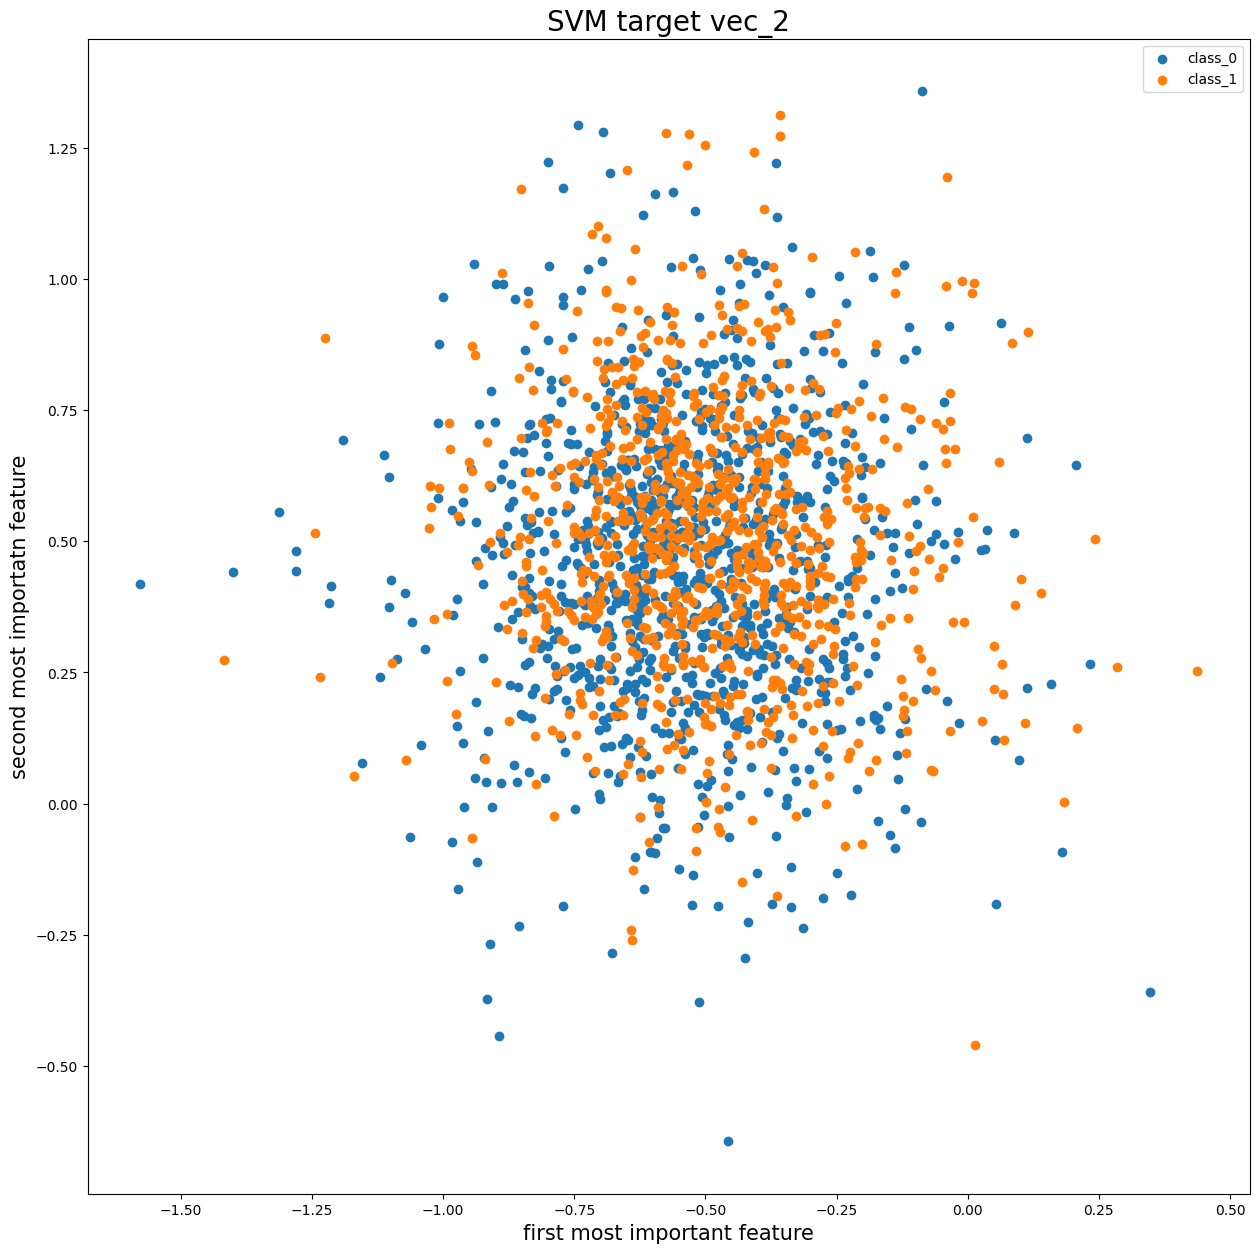

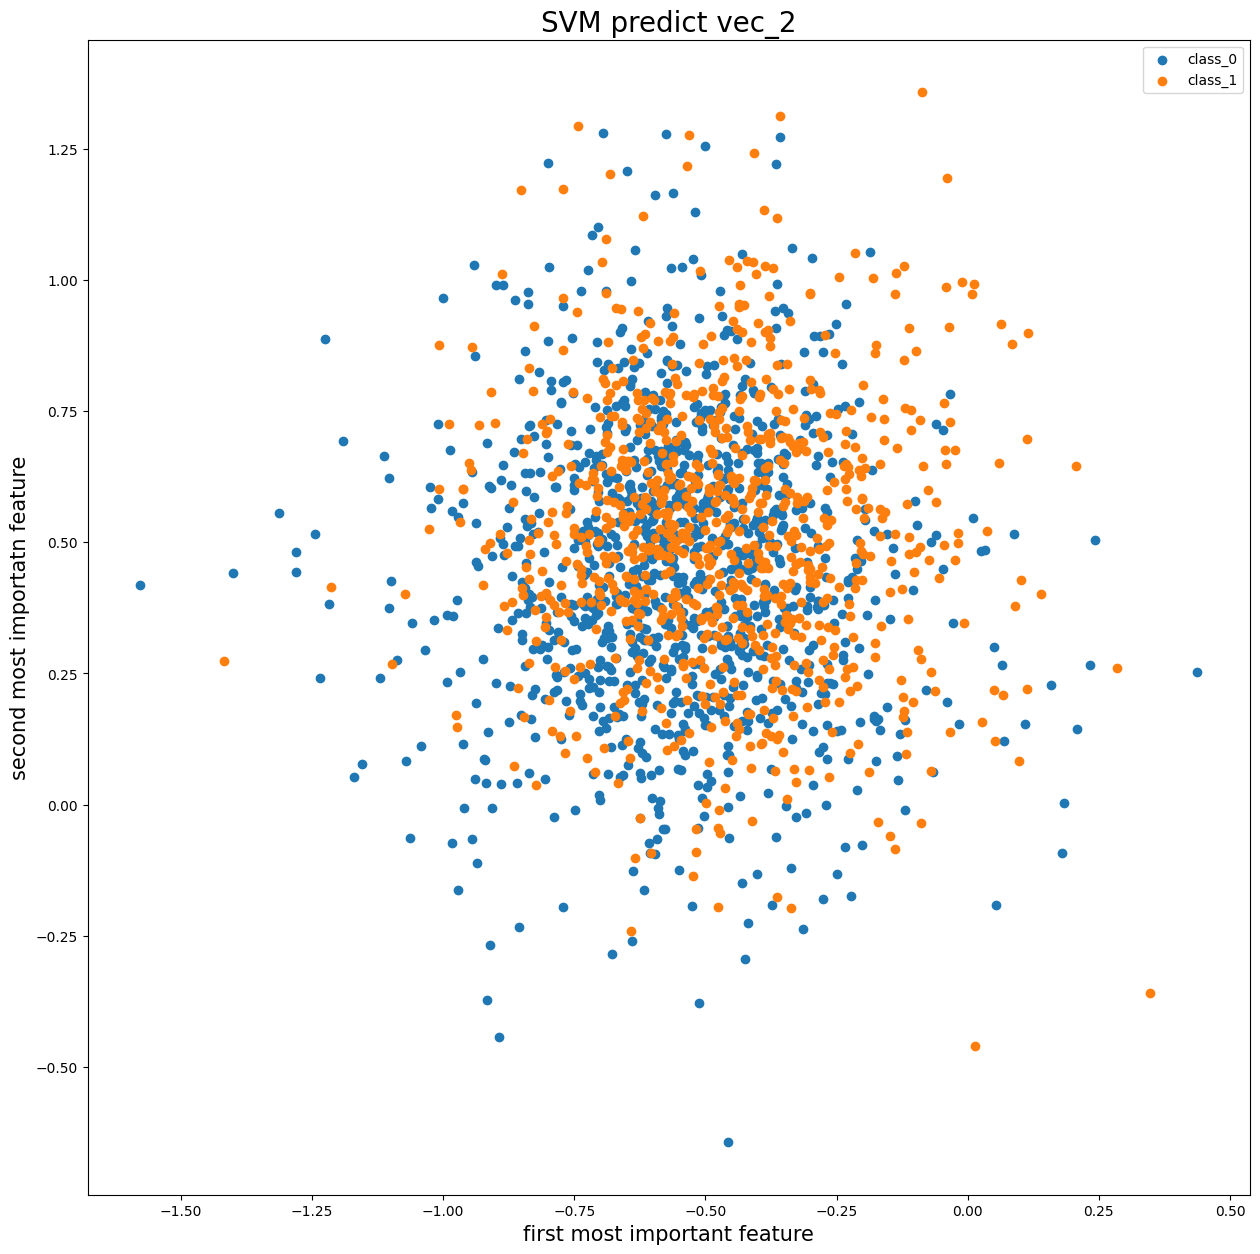

In [54]:
'''
    SVM
'''
plot_classes(data_test_vec_1, y_test_vec_1, 'SVM target vec_1')
plot_classes(data_test_vec_1, SVM_best_predict_1, 'SVM predict vec_1')

plot_classes(data_test_vec_2, y_test_vec_2, 'SVM target vec_2')
plot_classes(data_test_vec_2, SVM_best_predict_2, 'SVM predict vec_2')

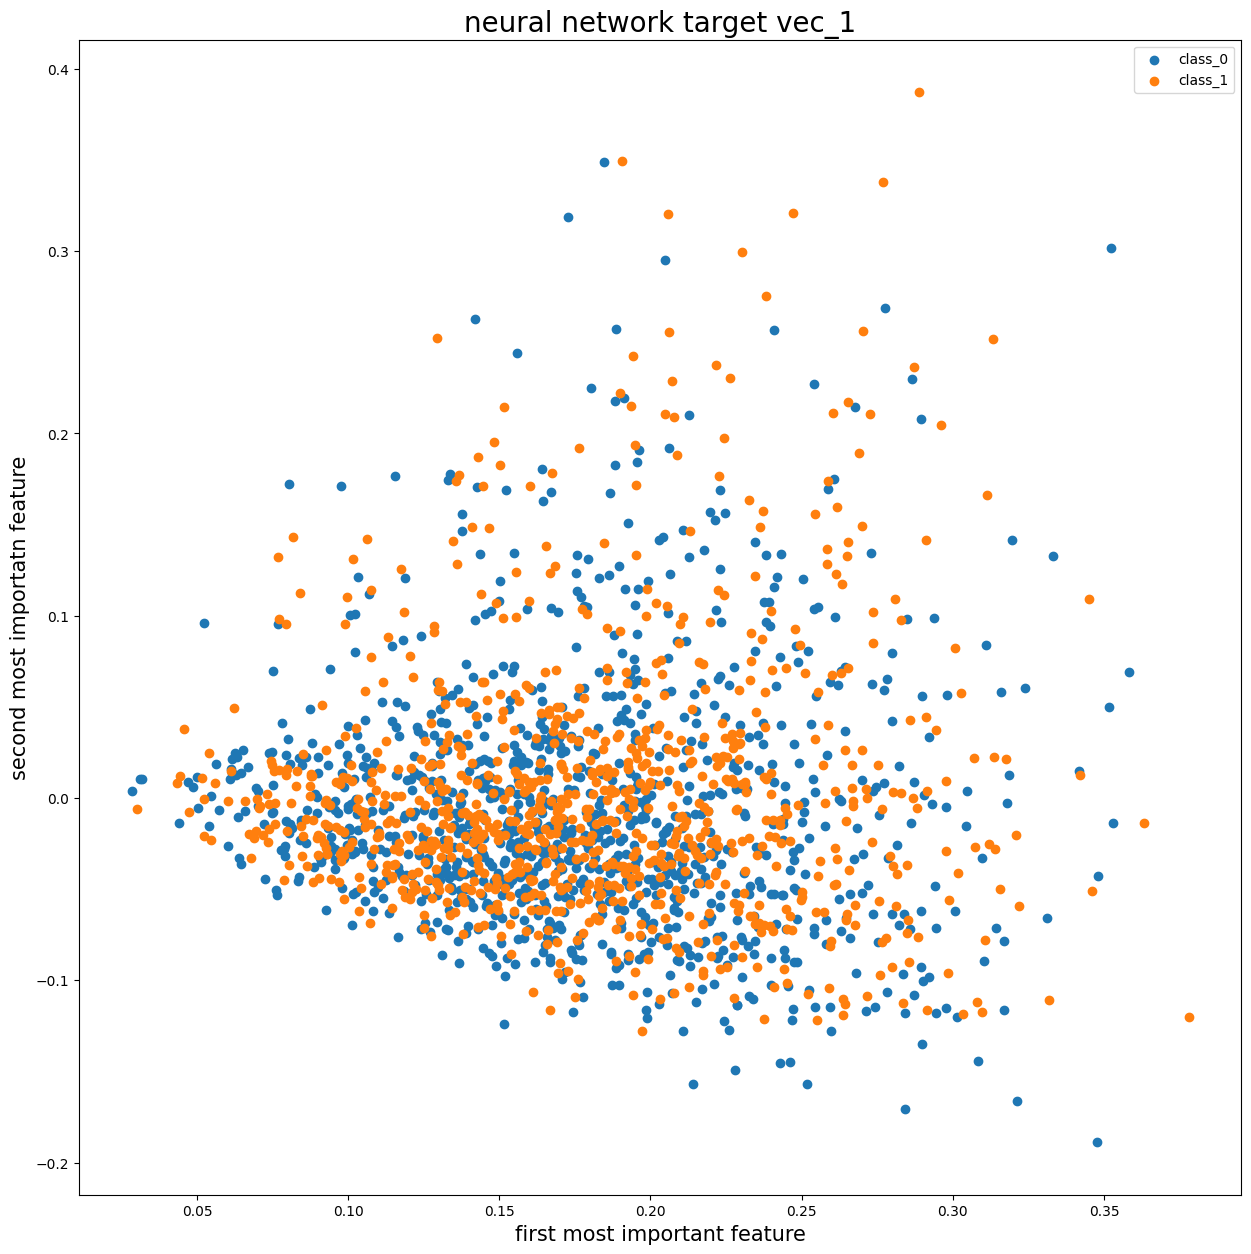

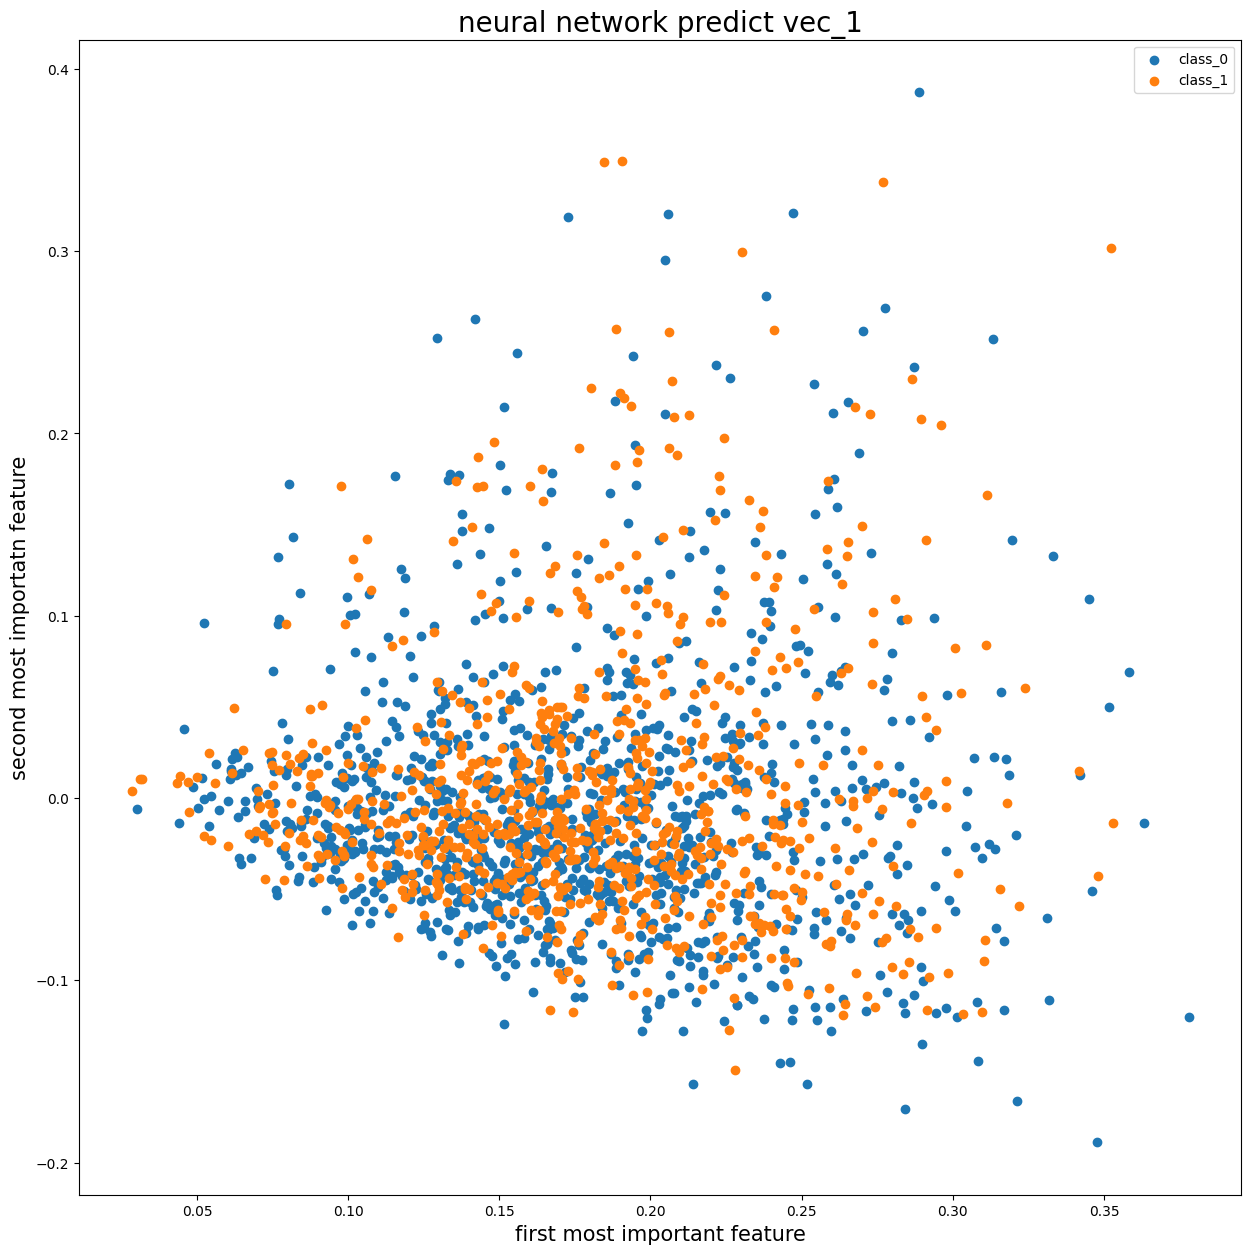

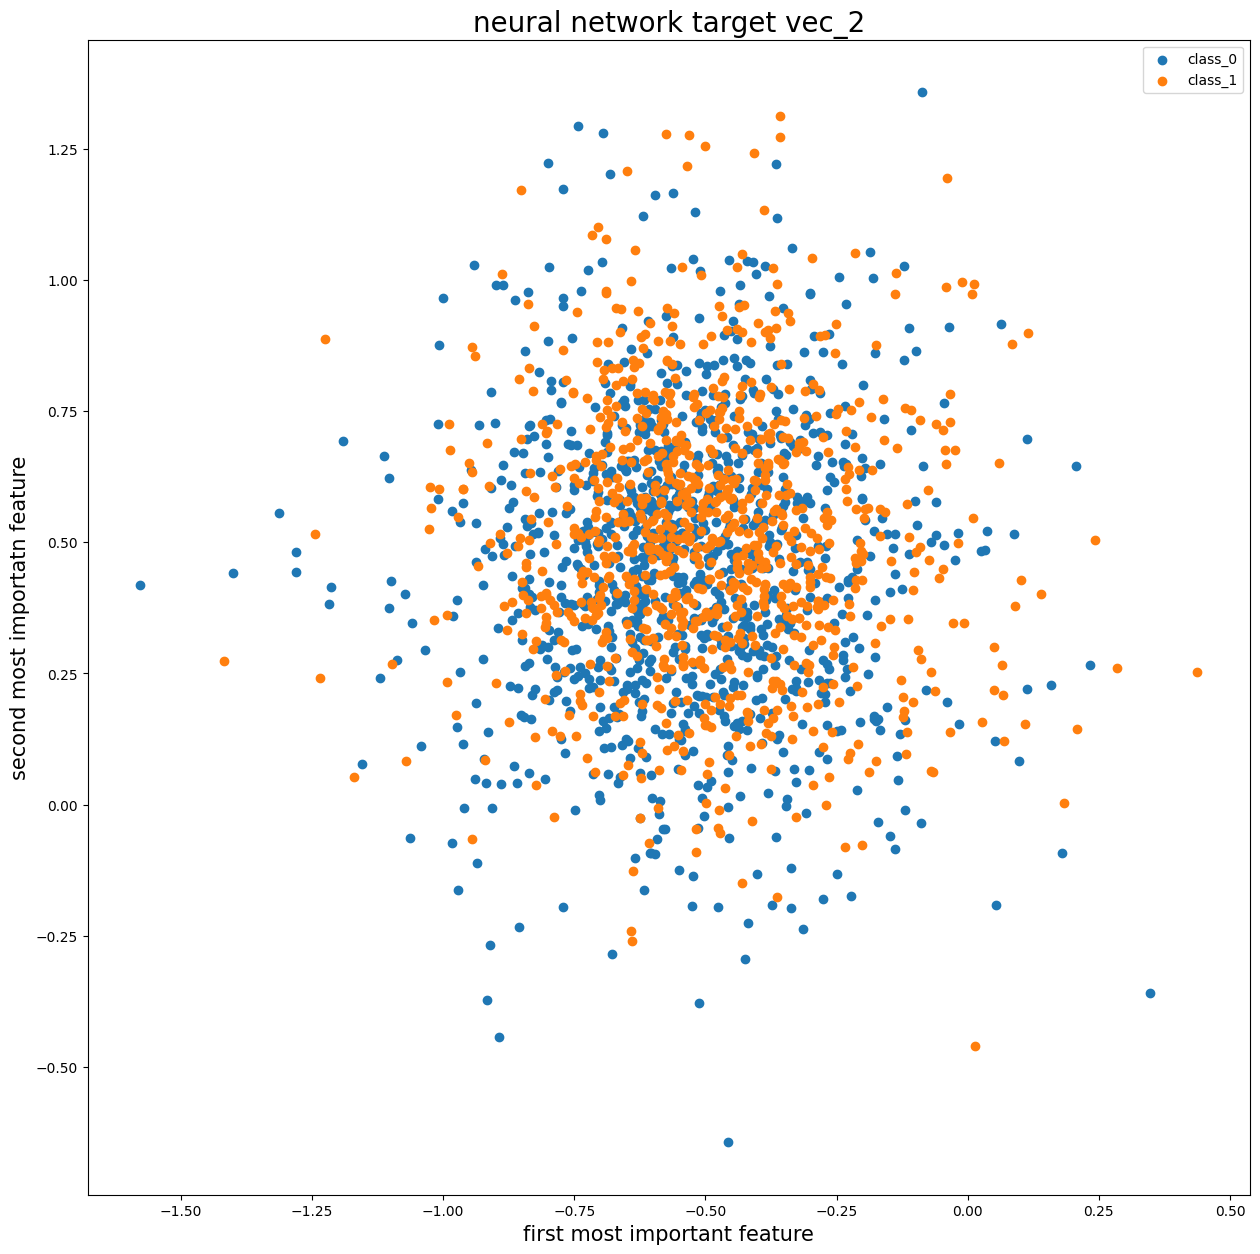

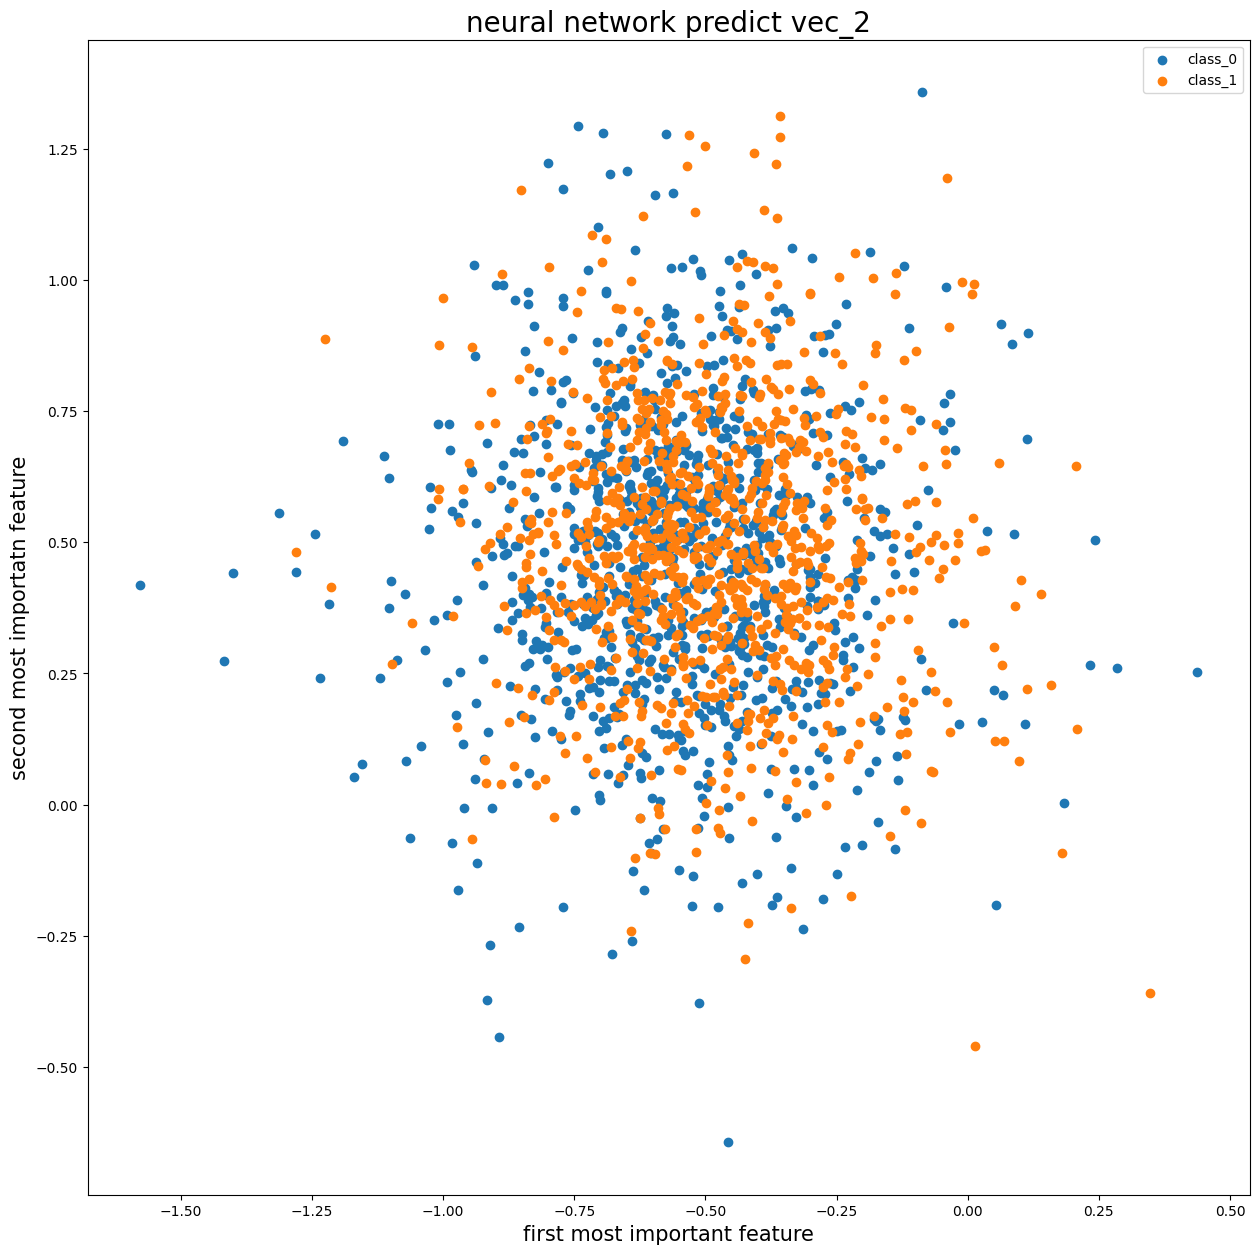

In [55]:
'''
    neural network
'''
plot_classes(data_test_vec_1, y_test_vec_1, 'neural network target vec_1')
plot_classes(data_test_vec_1, NN_best_predict_1, 'neural network predict vec_1')

plot_classes(data_test_vec_2, y_test_vec_2, 'neural network target vec_2')
plot_classes(data_test_vec_2, NN_best_predict_2, 'neural network predict vec_2')

# Clustering

In [57]:
class Evaluation_clustering:
    def __init__(self, predict, target):
        self.predict = predict
        self.target = target
        
    def purity(self):
        contingency_matrix = metrics.cluster.contingency_matrix(self.target, self.predict)
        return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

    def ARI(self):
        return metrics.cluster.adjusted_rand_score(self.target, self.predict)

In [58]:
train_clus = pd.concat([train_split, val_split], axis = 0, ignore_index=True)

In [59]:
data_train_clus_vec_1 = vectorize_df(train_clus, 'vec_1')
X_train_clus_vec_1, y_train_clus_vec_1 = split_X_y(data_train_clus_vec_1, 'popularity')

data_train_clus_vec_2 = vectorize_df(train_clus, 'vec_2')
X_train_clus_vec_2, y_train_clus_vec_2 = split_X_y(data_train_clus_vec_2, 'popularity')

## K-means

In [84]:
class K_Mean:
    def __init__(self, k, X, tol = 10**-4, max_iter = 300):
        self.k = k
        self.X = np.array(X)
        self.tol = tol
        self.max_iter = max_iter

    def fit(self):
        init_idx = np.random.choice(np.arange(self.X.shape[0]), replace=False, size = self.k)
        self.centroids = self.X[init_idx]

        for iter in range(self.max_iter):
            X = self.X
            C = self.centroids

            nx = len(X)
            nc = len(C)

            ox = np.ones((nx,1))
            oc = np.ones((nc, 1))

            XC = np.dot(X, C.T)
            XX = np.sum(X**2, axis=1).reshape(1,nx)
            CC = np.sum(C**2, axis=1).reshape(1,nc)

            Mc = np.dot(ox, CC)
            Mx = np.dot(oc, XX).T

            distance = Mx + Mc - 2 * XC
            nearest_idx = distance.argmin(axis=1)

            new_centroids = np.zeros(self.centroids.shape)
            for j in range(self.k):
                idx = nearest_idx == j
                Xj = X[idx]
                nj = len(Xj)
                m = np.sum(Xj, axis=0) / (nj + 10**-10)
                new_centroids[j] = m

            cosine = self.cosine(self.centroids, new_centroids)
            if cosine > 1-self.tol:
                self.centroids = new_centroids
                self.nearest_idx = nearest_idx
                break
            
            self.centroids = new_centroids
            self.nearest_idx = nearest_idx

    def cosine(self,X,Y):
        return np.sum(np.sum(X*Y, axis= 1), axis = 0) / np.sqrt(np.sum(np.sum(X**2, axis=1), axis=0) * np.sum(np.sum(Y**2, axis=1), axis=0))

    def predict(self, X_test):
        X = np.array(X_test)
        C = self.centroids

        nx = len(X)
        nc = len(C)

        ox = np.ones((nx,1))
        oc = np.ones((nc, 1))

        XC = np.dot(X, C.T)
        XX = np.sum(X**2, axis=1).reshape(1,nx)
        CC = np.sum(C**2, axis=1).reshape(1,nc)

        Mc = np.dot(ox, CC)
        Mx = np.dot(oc, XX).T

        distance = Mx + Mc - 2 * XC
        nearest_idx = distance.argmin(axis=1)
        return nearest_idx

In [85]:
ks = [2,4,8,16,32,64,128,256]

best_purity = 0
kmean_best_1 = None
kmean_best_k_1 = None

for k in ks:
    kmean = K_Mean(k, X_train_clus_vec_1)
    kmean.fit()
    predict = kmean.predict(X_train_clus_vec_1)
    eval = Evaluation_clustering(predict, y_train_clus_vec_1)
    purity =eval.purity()
    ARI = eval.ARI()
    print('kmean', 'vec_1, k:', k, 'purity:', purity, 'ARI:', ARI)
    if purity > best_purity:
        best_purity = purity
        kmean_best_1 = kmean
        kmean_best_k_1 = k

kmean_best_predict_1 = kmean_best_1.predict(X_test_vec_1)
kmean_best_eval_1 = Evaluation_clustering(kmean_best_predict_1, y_test_vec_1)

print('best kmean', 'vec_1, k:', kmean_best_k_1, 'purity:', kmean_best_eval_1.purity(), 'ARI:', kmean_best_eval_1.ARI())


best_purity = 0
kmean_best_2 = None
kmean_best_k_2 = None

for k in ks:
    kmean = K_Mean(k, X_train_clus_vec_2)
    kmean.fit()
    predict = kmean.predict(X_train_clus_vec_2)
    eval = Evaluation_clustering(predict, y_train_clus_vec_2)
    purity =eval.purity()
    ARI = eval.ARI()
    print('kmean', 'vec_2, k:', k, 'purity:', purity, 'ARI:', ARI)
    if purity > best_purity:
        best_purity = purity
        kmean_best_2 = kmean
        kmean_best_k_2 = k

kmean_best_predict_2 = kmean_best_2.predict(X_test_vec_2)
kmean_best_eval_2 = Evaluation_clustering(kmean_best_predict_2, y_test_vec_2)
print('best kmean', 'vec_2, k:', kmean_best_k_2, 'purity:', kmean_best_eval_2.purity(), 'ARI:', kmean_best_eval_2.ARI())


kmean vec_1, k: 2 purity: 0.5372025126072724 ARI: 0.0034033493638724096
kmean vec_1, k: 4 purity: 0.5535698487127312 ARI: 0.006801392476325805
kmean vec_1, k: 8 purity: 0.6160311421746439 ARI: 0.0353270677036991
kmean vec_1, k: 16 purity: 0.6415995753339822 ARI: 0.0193095932754151
kmean vec_1, k: 32 purity: 0.6427497124657171 ARI: 0.014821449703410358
kmean vec_1, k: 64 purity: 0.6451384588162434 ARI: 0.011067567593240768
kmean vec_1, k: 128 purity: 0.6484119260373352 ARI: 0.005564576427946969
kmean vec_1, k: 256 purity: 0.6541626116960099 ARI: 0.0033927359844160027
best kmean vec_1, k: 256 purity: 0.6675050301810865 ARI: 0.0032389791271345675
kmean vec_2, k: 2 purity: 0.5372025126072724 ARI: 0.0034033493638724096
kmean vec_2, k: 4 purity: 0.5824117490931611 ARI: 0.018946071675100776
kmean vec_2, k: 8 purity: 0.5865699371848182 ARI: 0.013849238490985894
kmean vec_2, k: 16 purity: 0.5868353534459878 ARI: 0.005482776697409702
kmean vec_2, k: 32 purity: 0.6180660001769441 ARI: 0.005621051

## GMM

In [62]:
'''
    Gaussian Mixture comprasion
'''

n_comps=[2,4,8,32,128]

best_purity = 0
GM_best_1 = None
GM_best_n_1 = None

for n in n_comps:
    GM = GaussianMixture(n_components=n)
    GM.fit(X_train_vec_1)
    predict = GM.predict(X_train_vec_1)
    eval = Evaluation_clustering(predict, y_train_vec_1)
    purity = eval.purity()
    ARI = eval.ARI()
    print('Gaussian Mixture vec_1, components:', n, ', purity:', purity, ', ARI:', ARI)
    if purity > best_purity:
        best_purity = purity
        GM_best_1 = GM
        GM_best_n_1 = n

GM_best_predict_1 = GM_best_1.predict(X_test_vec_1)
GM_best_eval_1 = Evaluation_clustering(GM_best_predict_1, y_test_vec_1)
print('best Gaussian Mixture vec_1, components:', GM_best_n_1, ', purity:', GM_best_eval_1.purity(), ', ARI:', GM_best_eval_1.ARI())
    


best_purity = 0
GM_best_2 = None
GM_best_n_2 = None

for n in n_comps:
    GM = GaussianMixture(n_components=n)
    GM.fit(X_train_vec_2)
    predict = GM.predict(X_train_vec_2)
    eval = Evaluation_clustering(predict, y_train_vec_2)
    purity = eval.purity()
    ARI = eval.ARI()
    print('Gaussian Mixture vec_2, components:', n, ', purity:', purity, ', ARI:', ARI)
    if purity > best_purity:
        best_purity = purity
        GM_best_2 = GM
        GM_best_n_2 = n

GM_best_predict_2 = GM_best_2.predict(X_test_vec_2)
GM_best_eval_2 = Evaluation_clustering(GM_best_predict_2, y_test_vec_2)
print('best Gaussian Mixture vec_2, components:', GM_best_n_2, ', purity:', GM_best_eval_2.purity(), ', ARI:', GM_best_eval_2.ARI())

Gaussian Mixture vec_1, components: 2 , purity: 0.5520433284096504 , ARI: 0.010737094257435147
Gaussian Mixture vec_1, components: 4 , purity: 0.5946824224519941 , ARI: 0.02937366661802255
Gaussian Mixture vec_1, components: 8 , purity: 0.6419497784342688 , ARI: 0.025168354165670984
Gaussian Mixture vec_1, components: 32 , purity: 0.6473658296405711 , ARI: 0.01089955541964967
Gaussian Mixture vec_1, components: 128 , purity: 0.6535696701132447 , ARI: 0.0033992949156096334
best Gaussian Mixture vec_1, components: 128 , purity: 0.6433601609657947 , ARI: 0.02088472883158843
Gaussian Mixture vec_2, components: 2 , purity: 0.5358936484490399 , ARI: -0.00041732404793041284
Gaussian Mixture vec_2, components: 4 , purity: 0.571836533727228 , ARI: 0.00868765528568557
Gaussian Mixture vec_2, components: 8 , purity: 0.5750861644510094 , ARI: 0.006195341551788904
Gaussian Mixture vec_2, components: 32 , purity: 0.6192023633677991 , ARI: 0.0060852252072027815
Gaussian Mixture vec_2, components: 128

# Hierarchical Clustering

In [98]:

n_cluses = [2,4,8,32,128]

best_purity = 0
HC_best_1 = None
HC_best_n_1 = None

for n in n_cluses:
    clustering = AgglomerativeClustering(n_clusters=n)
    clustering.fit(X_train_clus_vec_1)
    predict = clustering.labels_
    eval = Evaluation_clustering(predict, y_train_clus_vec_1)
    purity = eval.purity()
    ARI = eval.ARI()
    print('Hierarchical Clustering vec_1, clusters:', n, ', purity:', purity, ', ARI:', ARI)
    if purity > best_purity:
        best_purity = purity
        HC_best_1 = clustering
        HC_best_n_1 = n


HC_best_predict_1 = HC_best_1.labels_
HC_best_eval_1 = Evaluation_clustering(HC_best_predict_1, y_train_clus_vec_1)
print('best Hierarchical Clustering vec_1, components:', HC_best_n_1, ', purity:', HC_best_eval_1.purity(), ', ARI:', HC_best_eval_1.ARI())


best_purity = 0
HC_best_2 = None
HC_best_n_2 = None

for n in n_cluses:
    clustering = AgglomerativeClustering(n_clusters=n)
    clustering.fit(X_train_clus_vec_2)
    predict = clustering.labels_
    eval = Evaluation_clustering(predict, y_train_clus_vec_2)
    purity = eval.purity()
    ARI = eval.ARI()
    print('Hierarchical Clustering vec_2, clusters:', n, ', purity:', purity, ', ARI:', ARI)
    if purity > best_purity:
        best_purity = purity
        HC_best_2 = clustering
        HC_best_n_2 = n


HC_best_predict_2 = HC_best_2.labels_
HC_best_eval_2 = Evaluation_clustering(HC_best_predict_2, y_train_clus_vec_2)
print('best Hierarchical Clustering vec_2, components:', HC_best_n_2, ', purity:', HC_best_eval_2.purity(), ', ARI:', HC_best_eval_2.ARI())

Hierarchical Clustering vec_1, clusters: 2 , purity: 0.5372025126072724 , ARI: 0.0034033493638724096
Hierarchical Clustering vec_1, clusters: 4 , purity: 0.5409183402636468 , ARI: 0.007040333430399494
Hierarchical Clustering vec_1, clusters: 8 , purity: 0.6407148544634168 , ARI: 0.024799854159588422
Hierarchical Clustering vec_1, clusters: 32 , purity: 0.6458462355126957 , ARI: 0.012828887487641195
Hierarchical Clustering vec_1, clusters: 128 , purity: 0.6527470583031054 , ARI: 0.004407255633630538
best Hierarchical Clustering vec_1, components: 128 , purity: 0.6527470583031054 , ARI: 0.004407255633630538
Hierarchical Clustering vec_2, clusters: 2 , purity: 0.5372025126072724 , ARI: 0.0013082418343440046
Hierarchical Clustering vec_2, clusters: 4 , purity: 0.5577280368043882 , ARI: 0.0067945188478846265
Hierarchical Clustering vec_2, clusters: 8 , purity: 0.5967442271963196 , ARI: 0.012958398414602832
Hierarchical Clustering vec_2, clusters: 32 , purity: 0.6066531009466514 , ARI: 0.006

# Analysis

In [69]:
'''
    vec_1
'''

cols = ['Purity', 'ARI']
kmean_col = [kmean_best_eval_1.purity(), kmean_best_eval_1.ARI()]
GM_col = [GM_best_eval_1.purity(), GM_best_eval_1.ARI()]
HC_col = [HC_best_eval_1.purity(), HC_best_eval_1.ARI()]

eval_df = pd.DataFrame()
eval_df['col'] = cols
eval_df['k-means'] = kmean_col
eval_df['GMM'] = GM_col
eval_df['Hierarchical'] = HC_col

print('vec_1:')
eval_df

vec_1:


col   k-means       GMM  Hierarchical
0  Purity  0.654870  0.643360      0.652747
1     ARI  0.003788  0.020885      0.004407

In [70]:
'''
    vec_2
'''

cols = ['Purity', 'ARI']
kmean_col = [kmean_best_eval_2.purity(), kmean_best_eval_2.ARI()]
GM_col = [GM_best_eval_2.purity(), GM_best_eval_2.ARI()]
HC_col = [HC_best_eval_2.purity(), HC_best_eval_2.ARI()]

eval_df = pd.DataFrame()
eval_df['col'] = cols
eval_df['k-means'] = kmean_col
eval_df['GMM'] = GM_col
eval_df['Hierarchical'] = HC_col

print('vec_2:')
eval_df

vec_2:


col   k-means       GMM  Hierarchical
0  Purity  0.649120  0.542757      0.629833
1     ARI  0.001849 -0.000555      0.001952

# Plots

In [71]:
def plot_cluster(df, y, title):
    classes = np.unique(y)
    plt.figure(figsize=(15,15))
    for c in classes:
        idx = y == c
        f0, f1 = df['f_0'][idx], df['f_1'][idx]
        plt.scatter(f0,f1, label='class_'+str(c))

    plt.legend()
    plt.xlabel('first most important feature', fontsize=15)
    plt.ylabel('second most importatn feature', fontsize=15)
    plt.title(title, fontsize=20)
    plt.show()

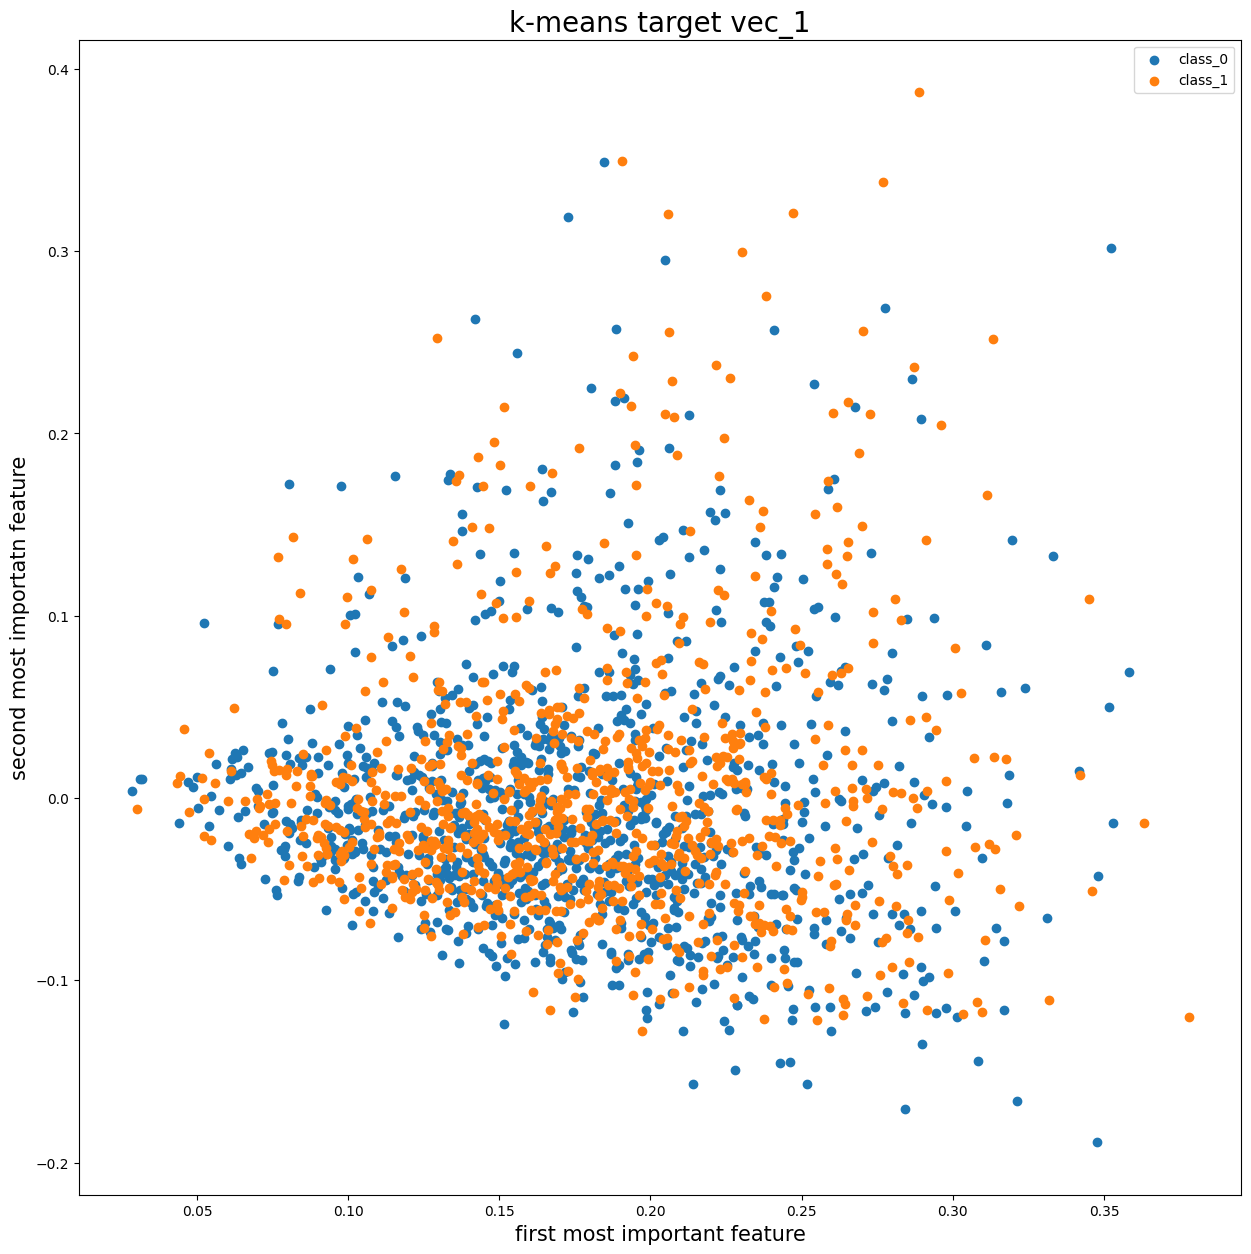

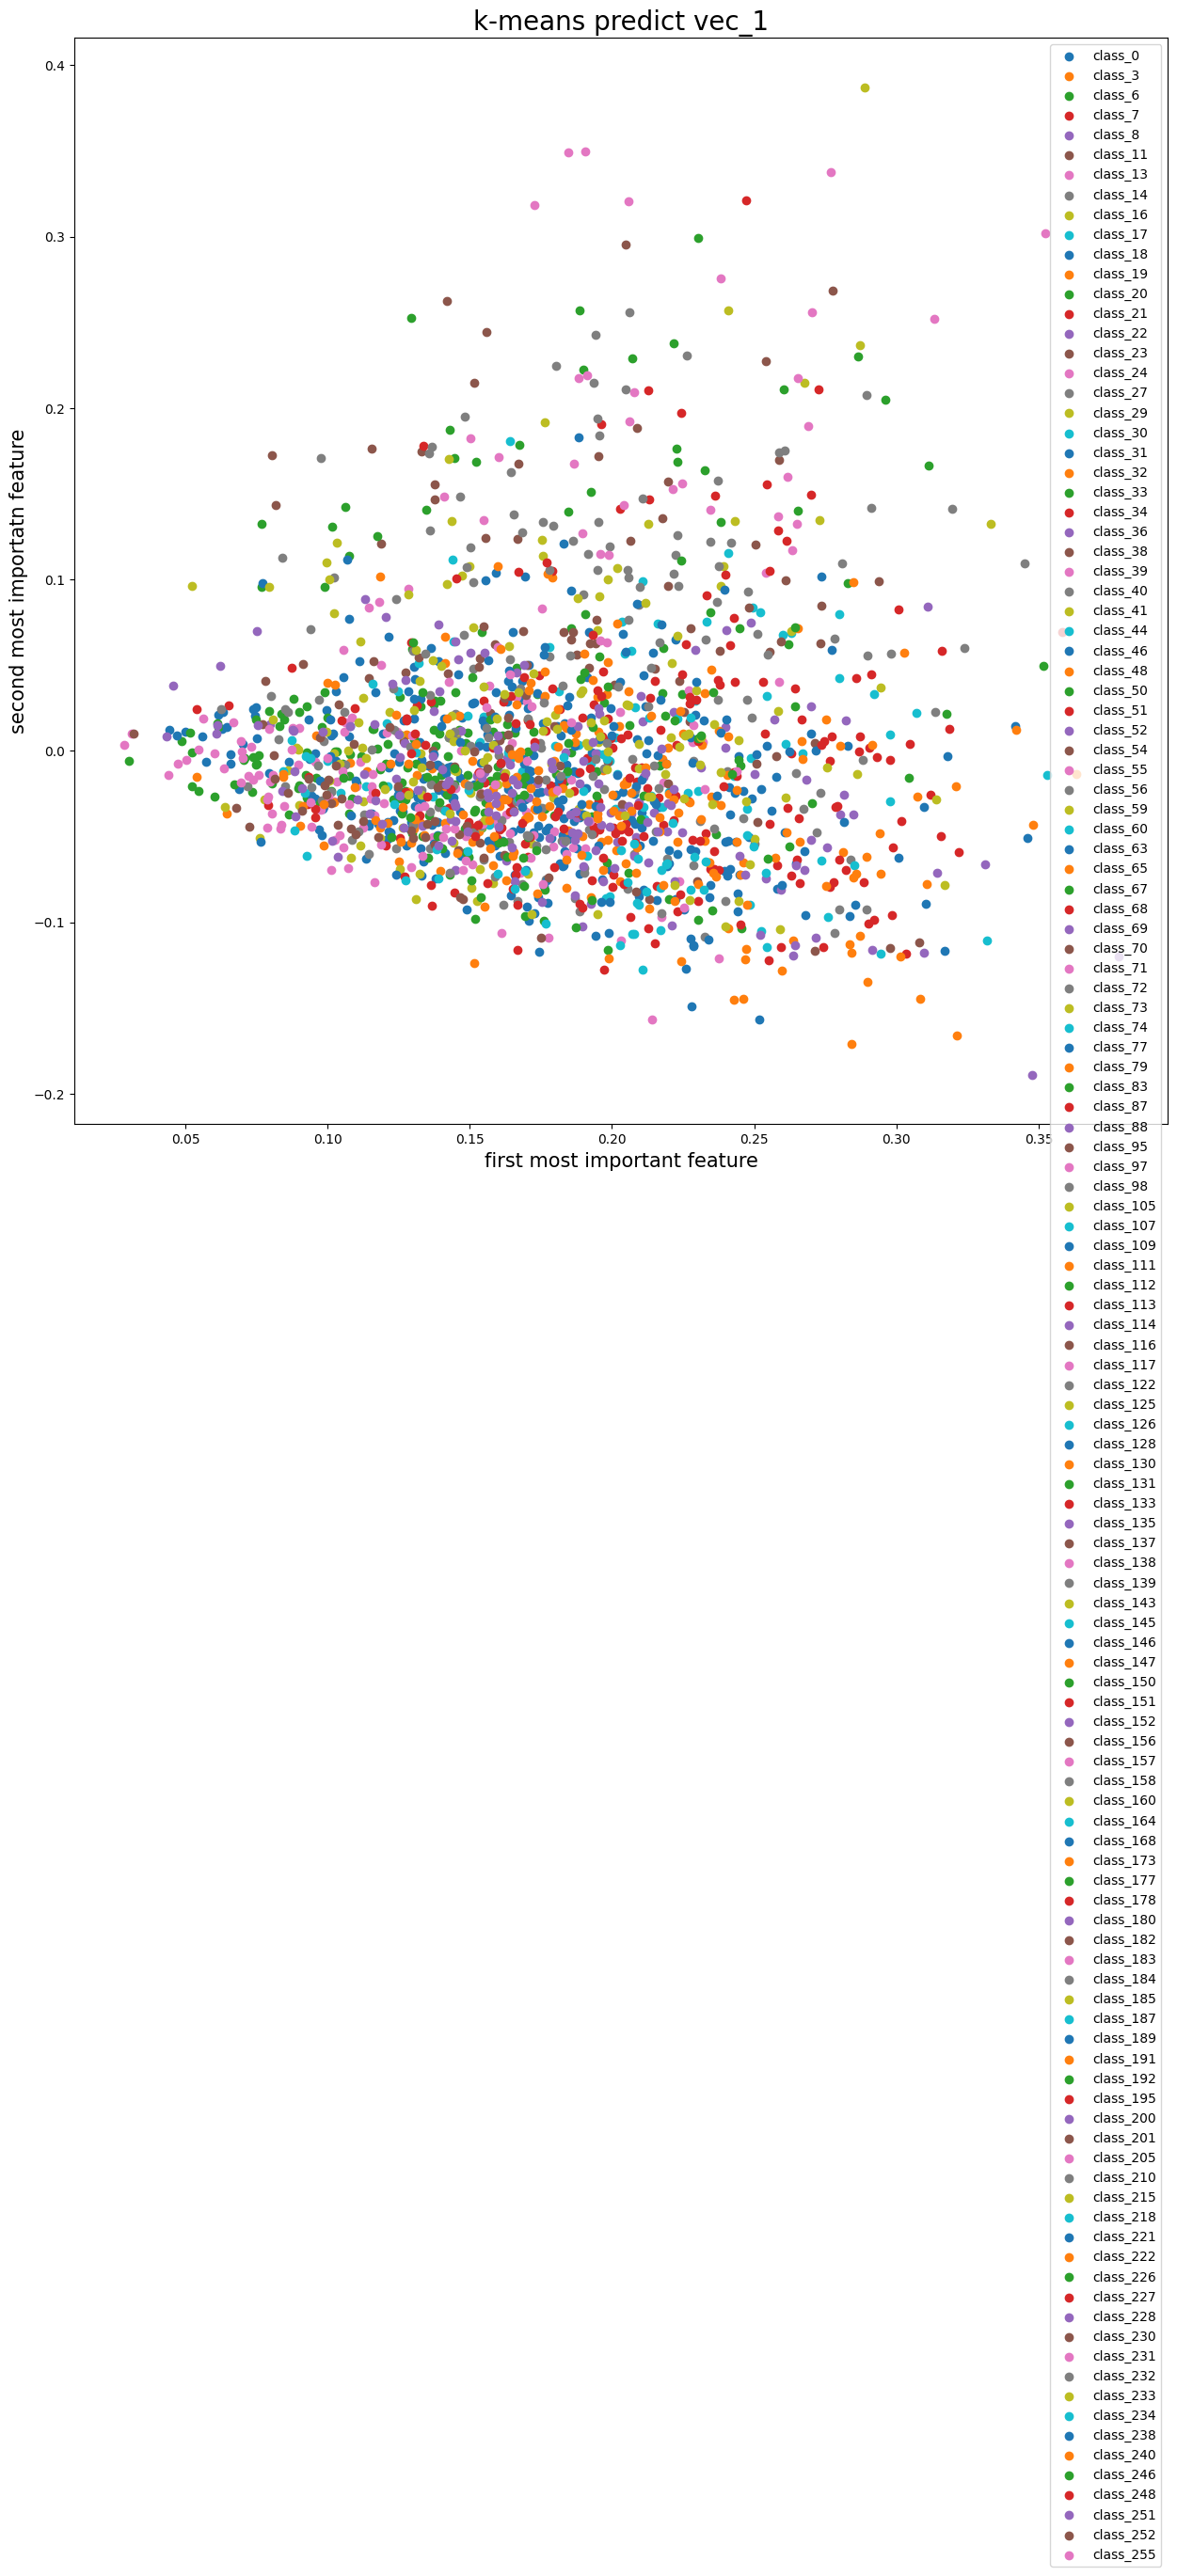

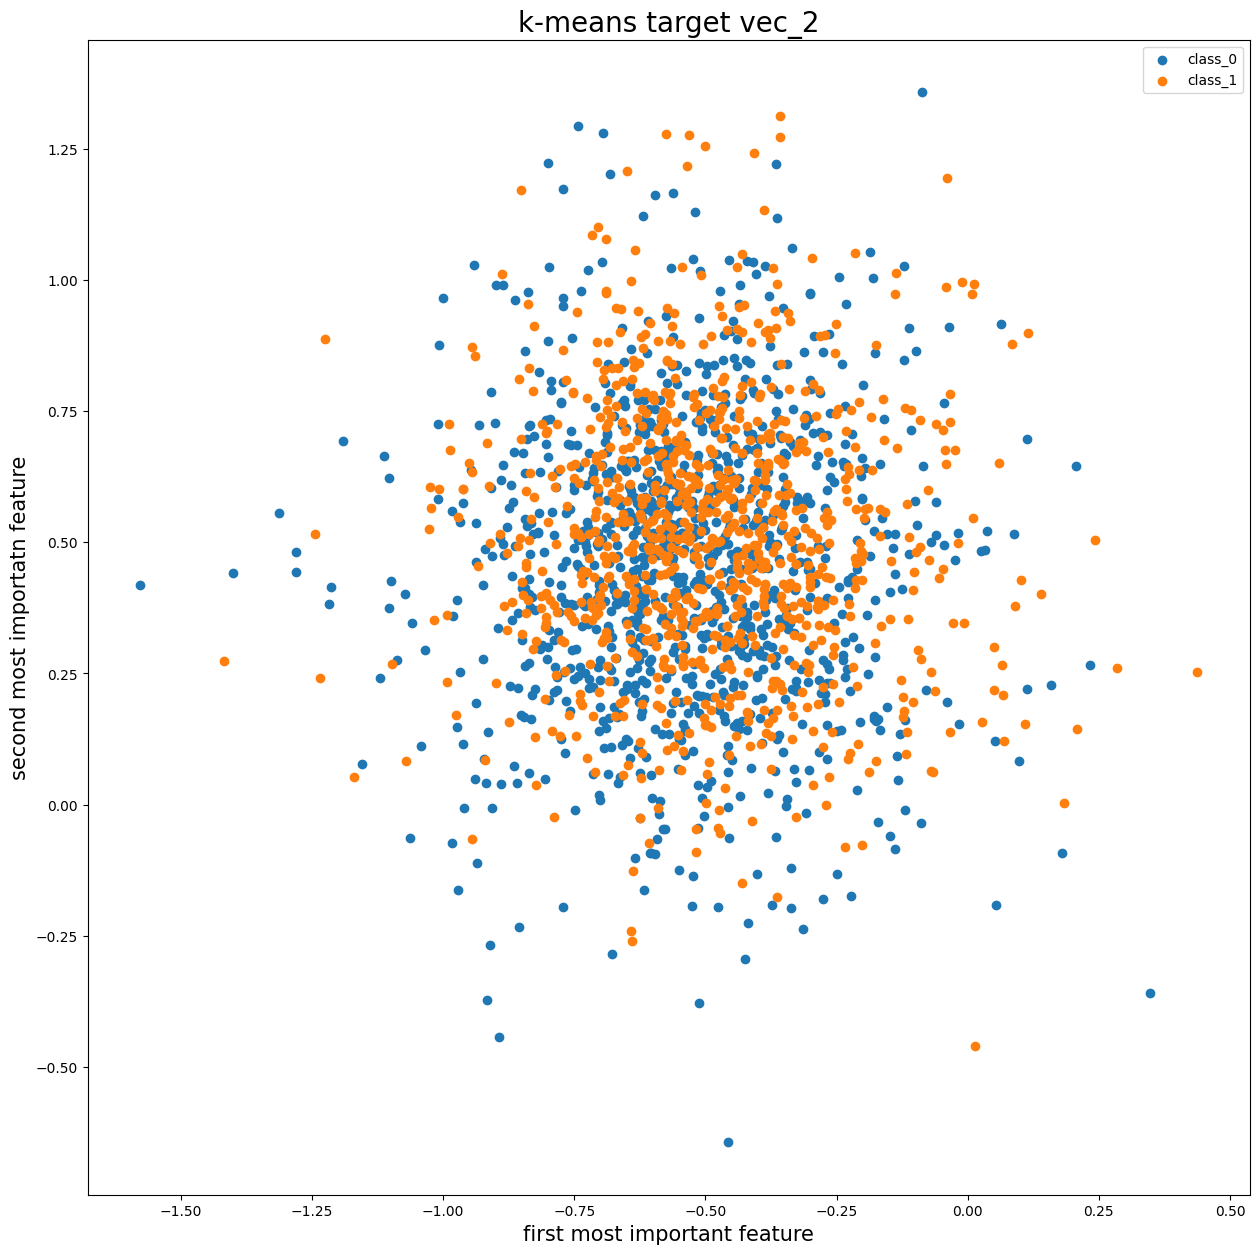

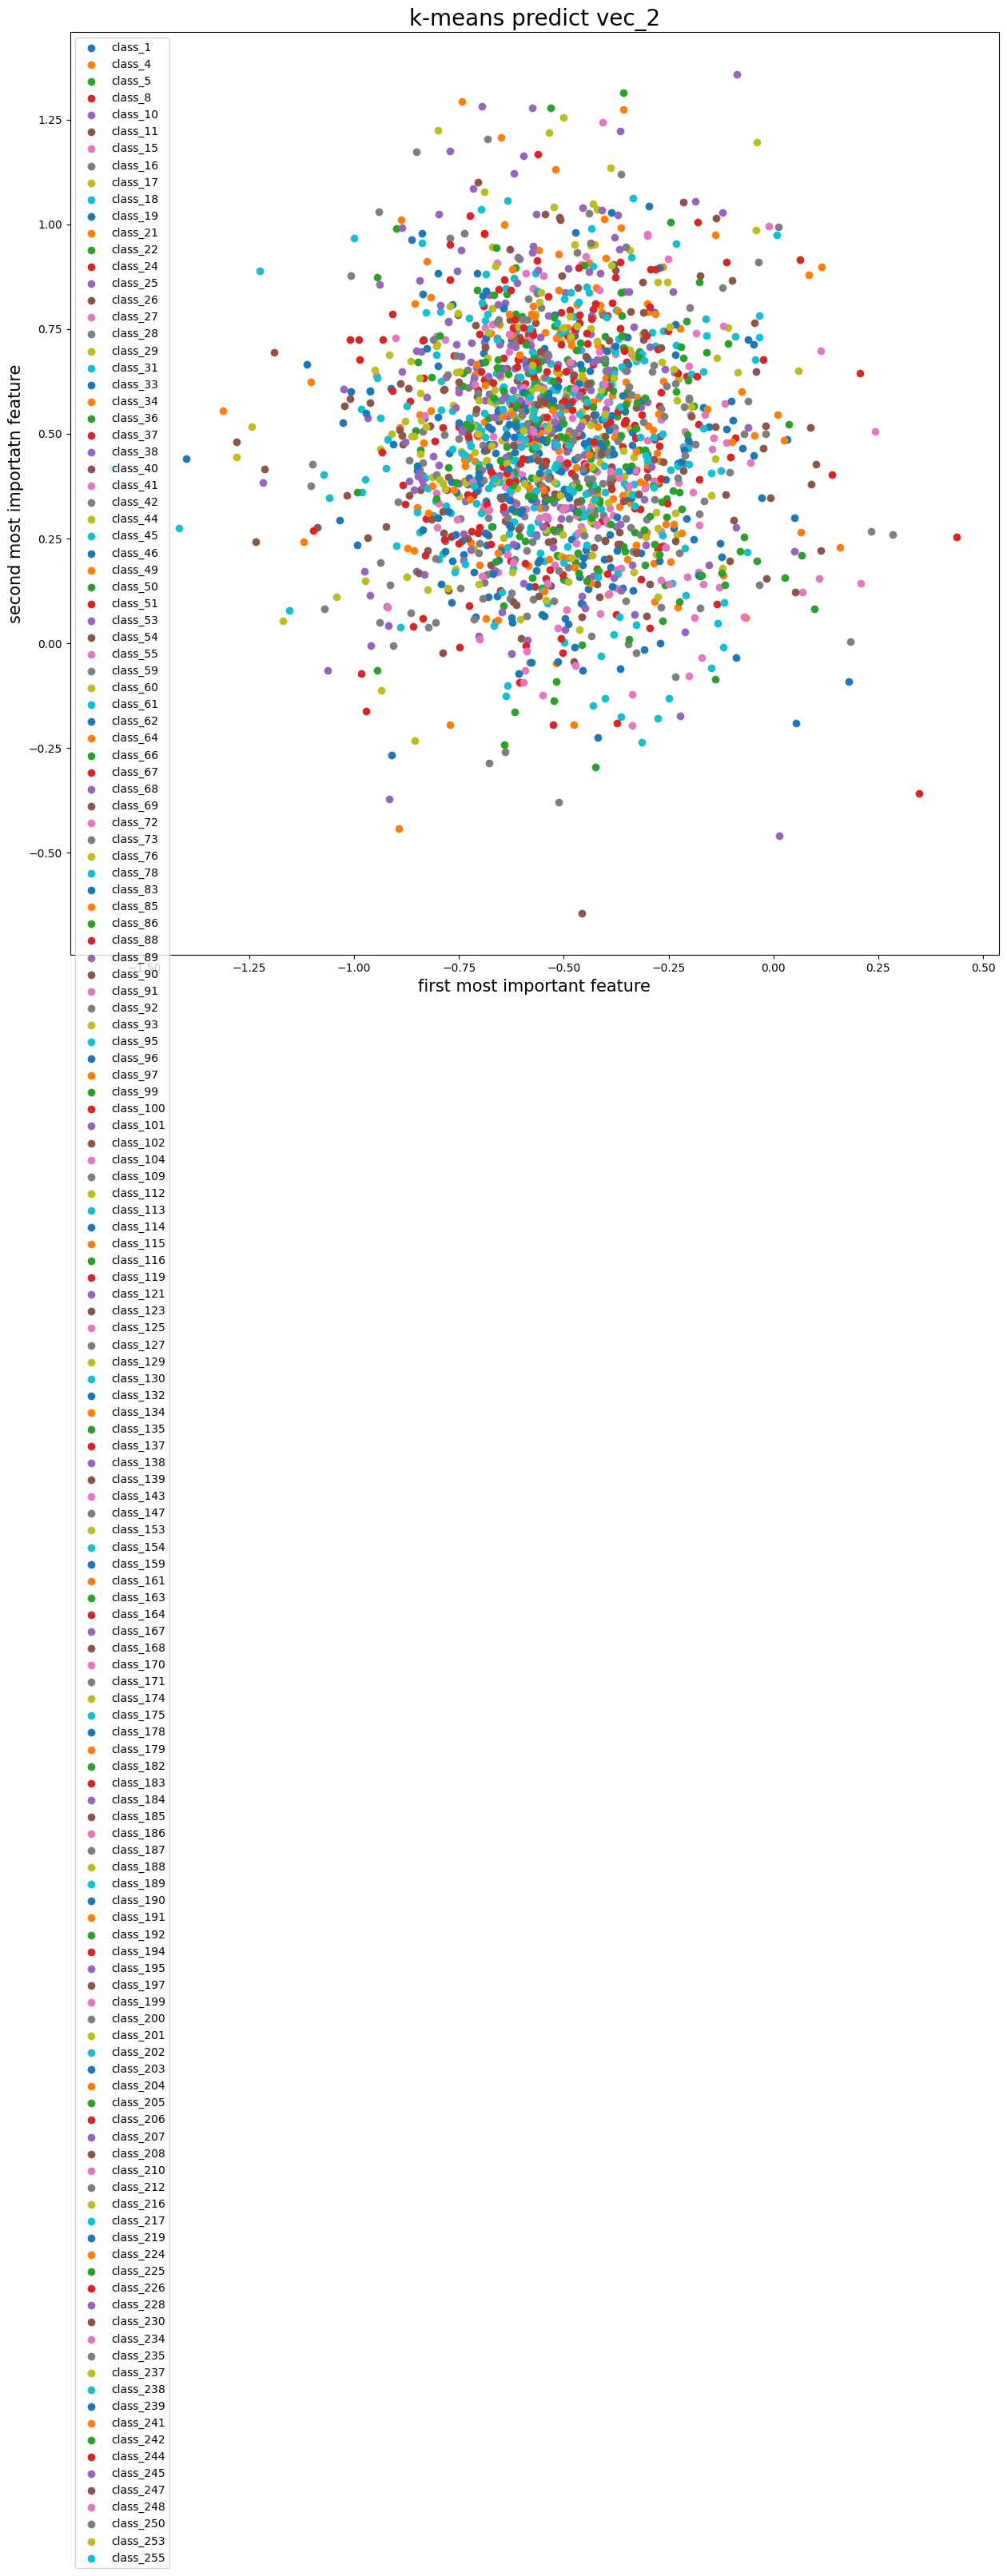

In [86]:
'''
    k-means
'''
plot_classes(data_test_vec_1, y_test_vec_1, 'k-means target vec_1')
plot_classes(data_test_vec_1, kmean_best_predict_1, 'k-means predict vec_1')

plot_classes(data_test_vec_2, y_test_vec_2, 'k-means target vec_2')
plot_classes(data_test_vec_2, kmean_best_predict_2, 'k-means predict vec_2')

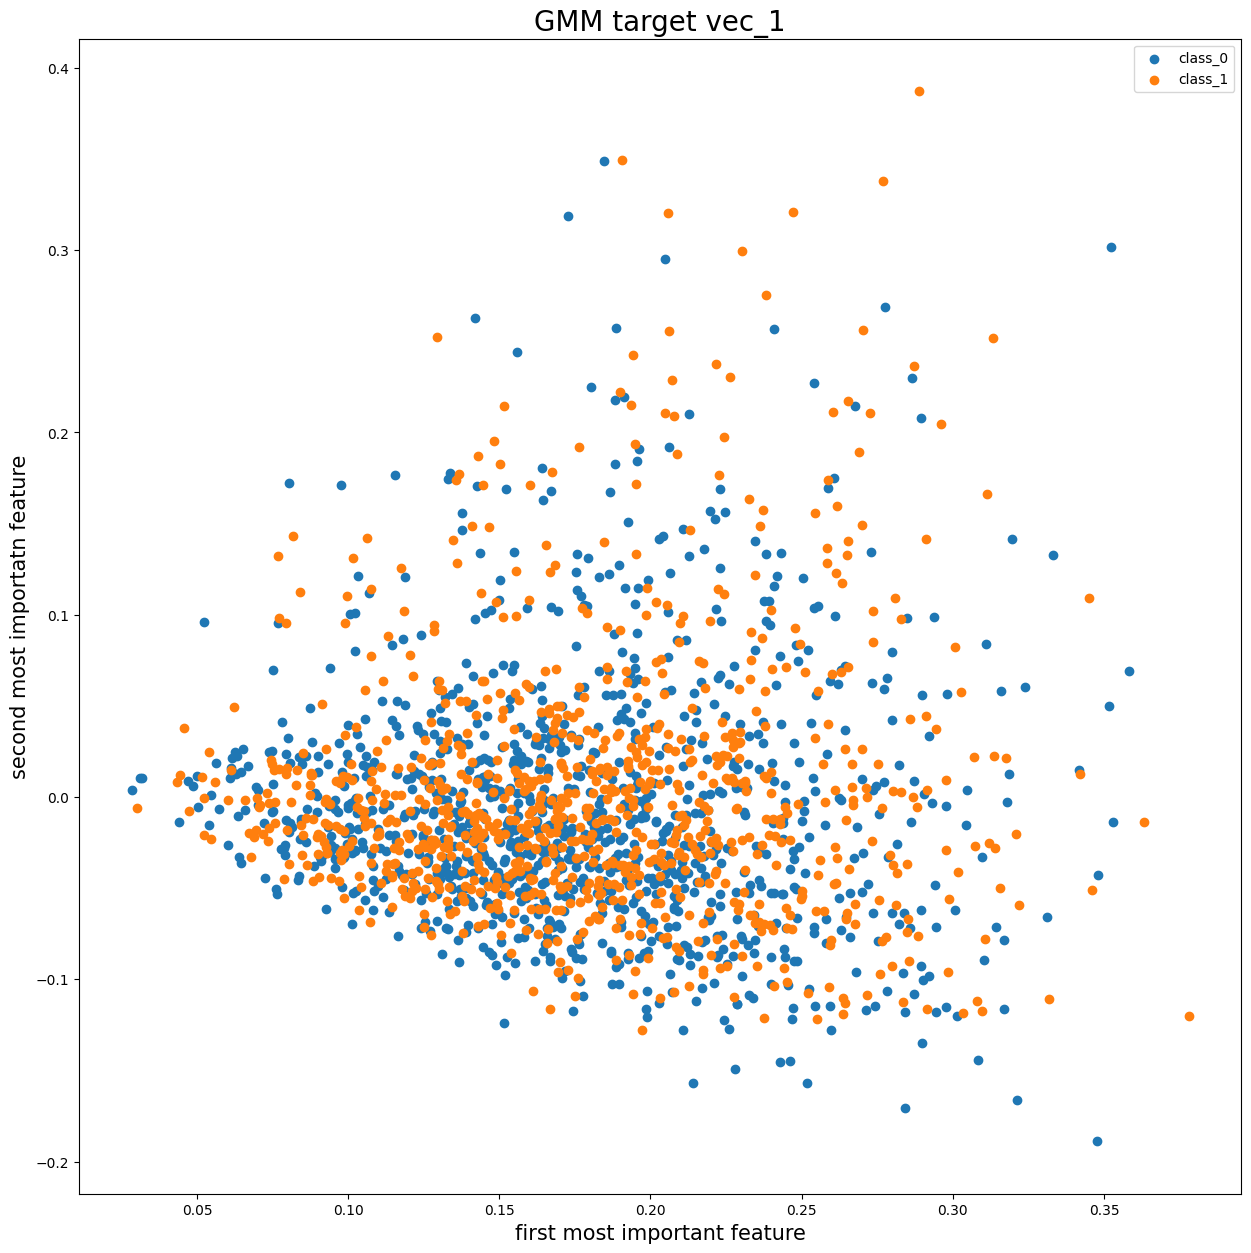

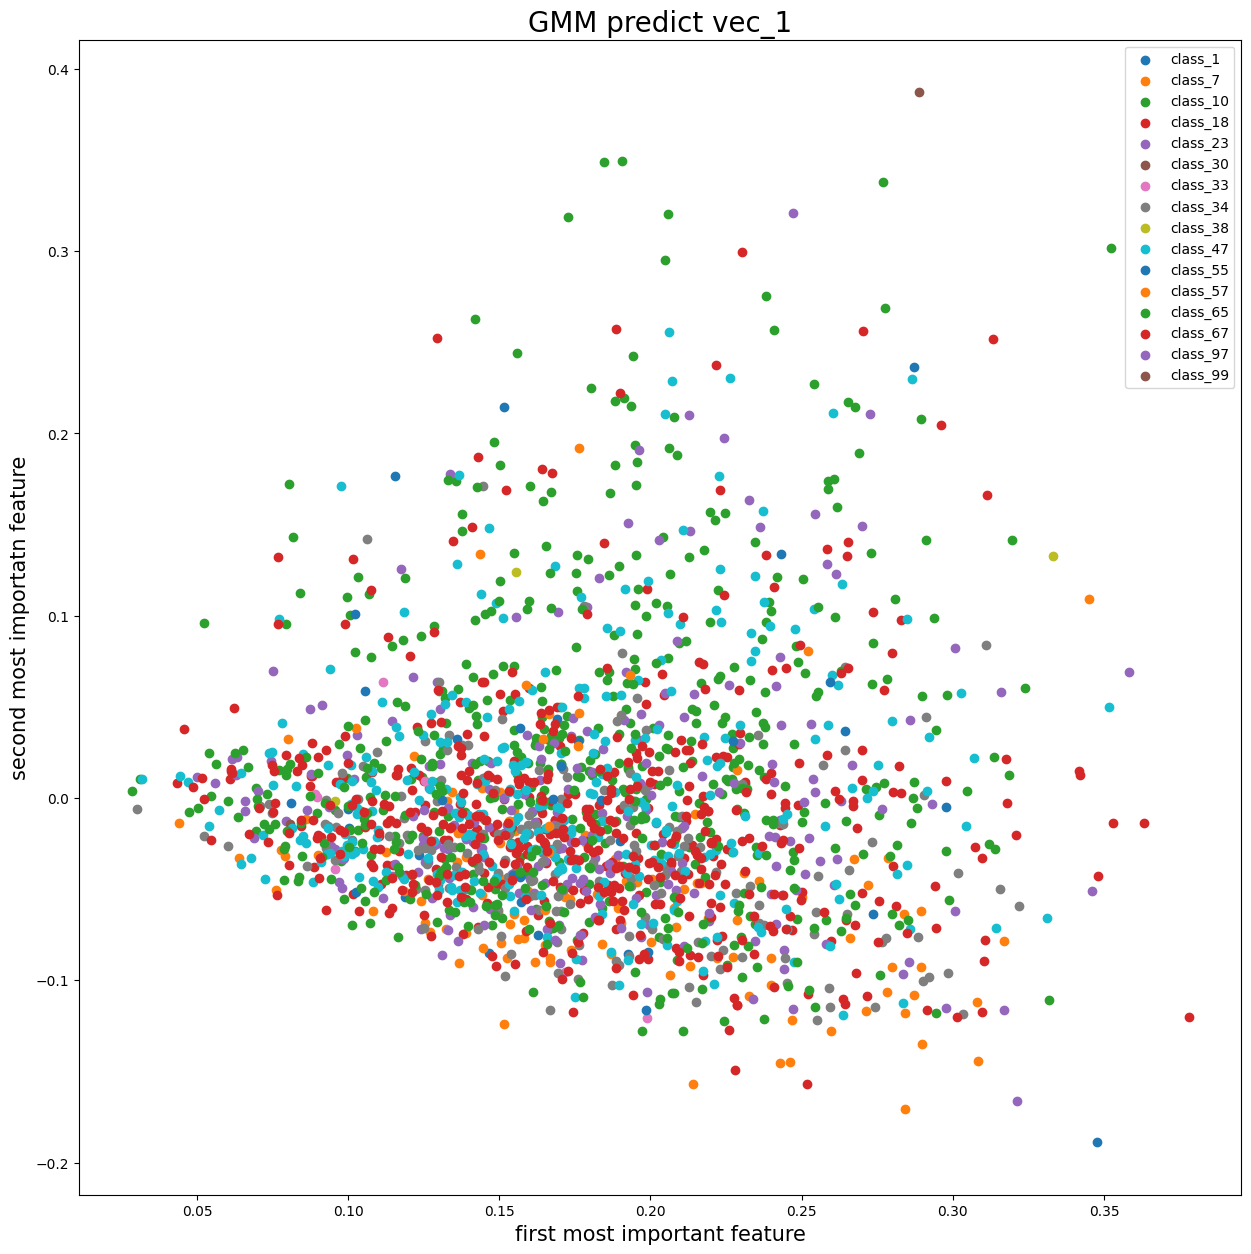

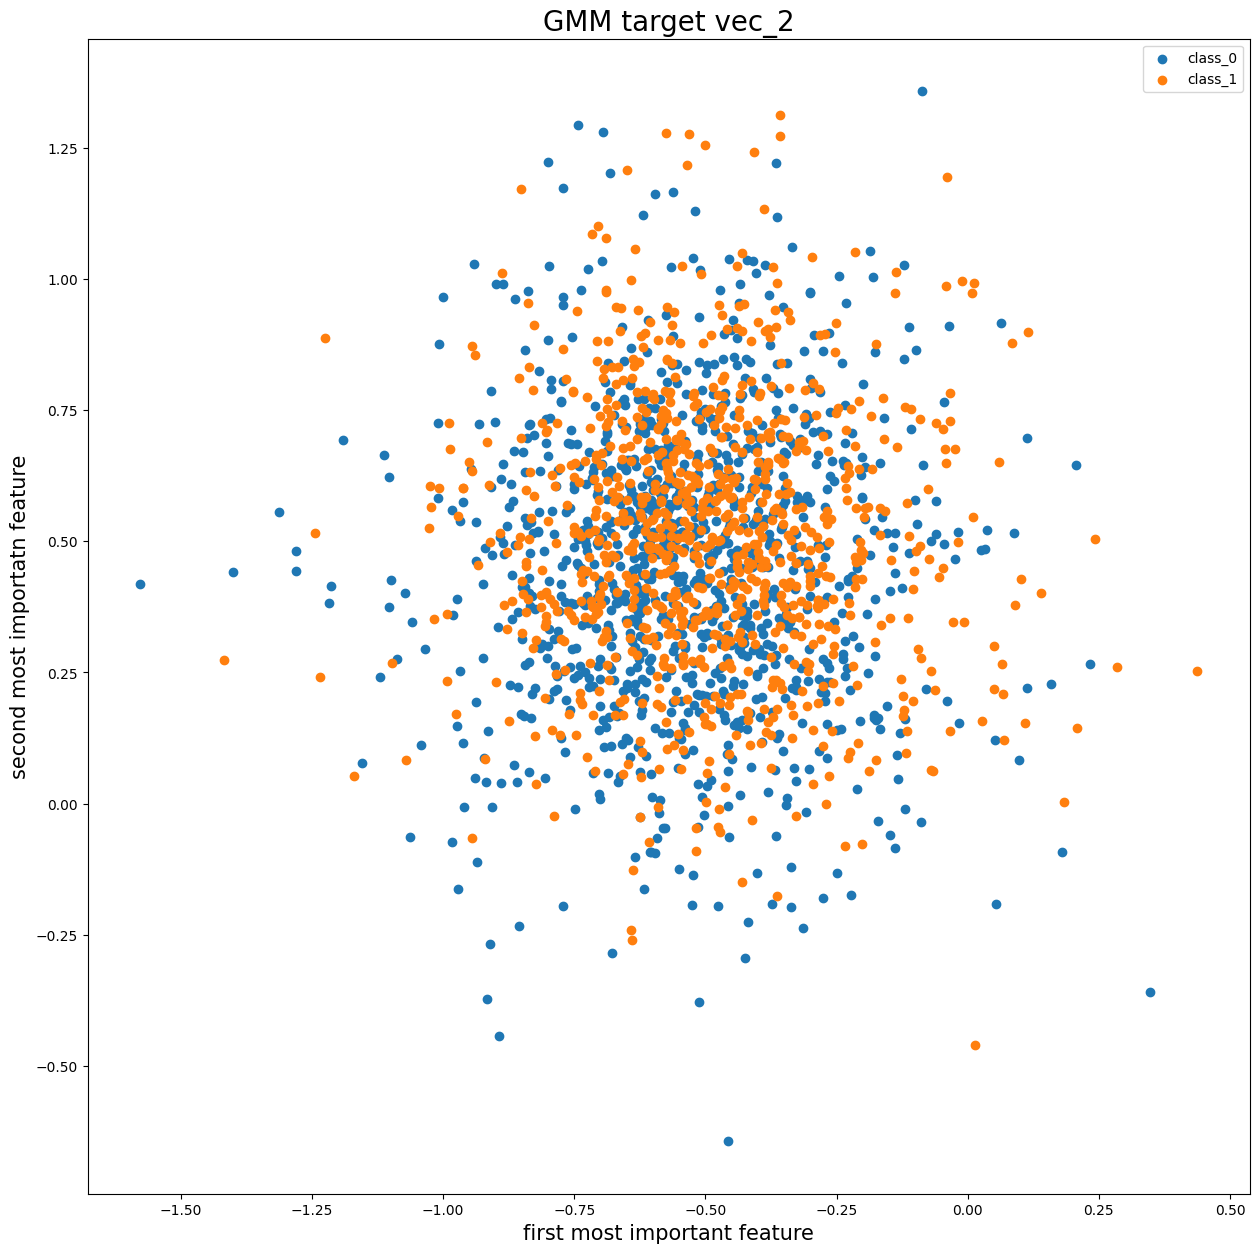

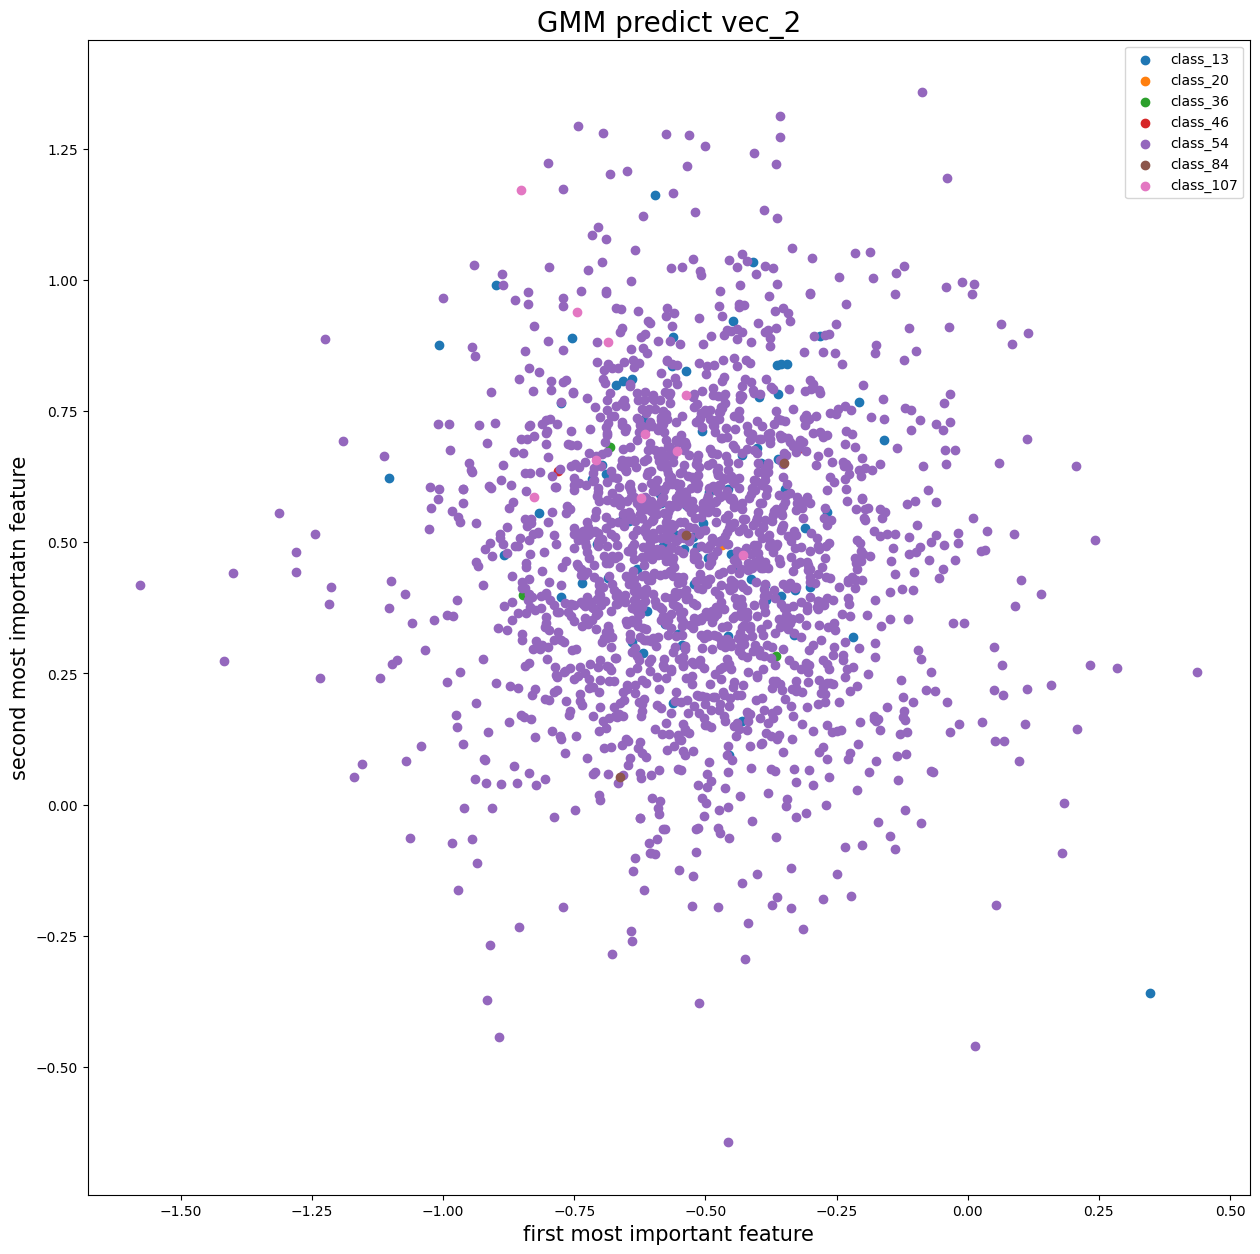

In [73]:
'''
    GMM
'''
plot_classes(data_test_vec_1, y_test_vec_1, 'GMM target vec_1')
plot_classes(data_test_vec_1, GM_best_predict_1, 'GMM predict vec_1')

plot_classes(data_test_vec_2, y_test_vec_2, 'GMM target vec_2')
plot_classes(data_test_vec_2, GM_best_predict_2, 'GMM predict vec_2')